In [3]:
# notebooks use their location as their working directory, so
# if we are in a subfolder, move to the main folder.  
# This however can safely be run multiple times
if(!dir.exists("Functions/")){
    setwd("../")
}
source("Functions/lecospectR.R", echo = FALSE)
library(class)
library(caret)
library(vegan)

## Load the Data

In [4]:
# spectral library
base_path <- "./Output/C_001_SC3_Cleaned_SpectralLib.csv"
veg_index_path <- "./Data/D_002_SpecLib_Derivs.csv"
speclib <- read.csv(base_path)
veg_indices <- read.csv(veg_index_path)

In [5]:
# Targets 
targets <- veg_indices[!is.na(veg_indices$Functional_group1),"Functional_group1"] %>% as.factor()
# weights
weights_by_pft <- targets_to_weights(targets)

In [6]:
# image-based validation
uav_speclib_df <- read.csv(
    "Data/Ground_Validation/PFT_image_spectra/PFT_Image_SpectralLib_Clean_unsmoothed.csv", 
    header = TRUE)
image_validation <- uav_speclib_df[,16:(ncol(uav_speclib_df) - 1)]
validation_labels <- uav_speclib_df$FncGrp1 %>% as.factor()
levels(validation_labels) <- c(
    levels(validation_labels),
    "Forb") 



## Base transformation
This removes infinity, outliers and NAs from the data.  

[1] "Imputing..."
[1] "Imputing..."


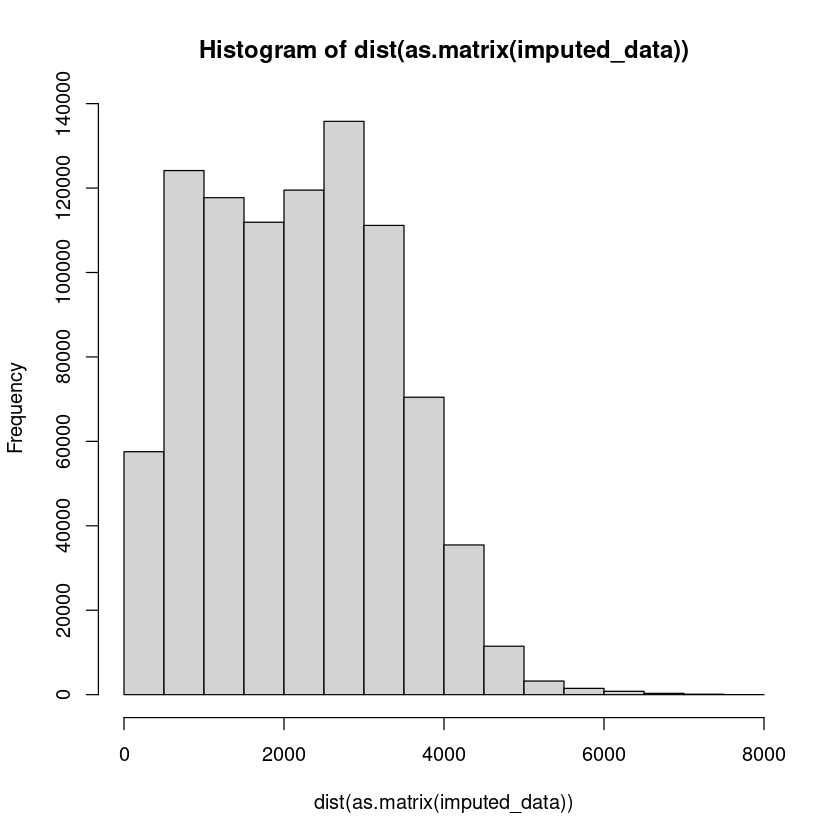

In [7]:
numeric_data <- veg_indices[!is.na(veg_indices$Functional_group1),35:195]
numeric_data <- inf_to_na(numeric_data)
imputed_data_1 <- impute_spectra(numeric_data)
imputed_data_no_outliers <- outliers_to_na(imputed_data_1)
imputed_data <- impute_spectra(imputed_data_no_outliers)
outlier_indices <- detect_outliers_columnwise(imputed_data[,1:95])
filtered_data <- imputed_data[!outlier_indices,]
hist(dist(as.matrix(imputed_data)))
min_max_scaled_data <- columnwise_min_max_scale(imputed_data)

## Transform the Image-based Data

In [8]:
veg_index_names <- read.csv("assets/vegIndicesUsed.csv")$x
validation_indices <- get_vegetation_indices(image_validation, NULL)
# drop NAs

validation_indices <- inf_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)
validation_indices <- outliers_to_na(validation_indices)
validation_indices <- impute_spectra(validation_indices)


min_max_scaled_validation <- columnwise_min_max_scale(validation_indices)

#hist(as.matrix(min_max_scaled_validation))

[1] "Imputing..."
[1] "Imputing..."


In [9]:
print(summary(min_max_scaled_validation))

     Boochs          Boochs2            CARI            Carter      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3747   1st Qu.:0.3757   1st Qu.:0.3217   1st Qu.:0.3660  
 Median :0.5013   Median :0.5181   Median :0.4347   Median :0.4847  
 Mean   :0.4977   Mean   :0.4983   Mean   :0.4865   Mean   :0.5027  
 3rd Qu.:0.6250   3rd Qu.:0.6259   3rd Qu.:0.5931   3rd Qu.:0.6073  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
    Carter2          Carter3          Carter4          Carter5      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.1930   1st Qu.:0.2054   1st Qu.:0.1946   1st Qu.:0.3347  
 Median :0.2411   Median :0.2582   Median :0.2585   Median :0.4781  
 Mean   :0.3931   Mean   :0.3992   Mean   :0.3801   Mean   :0.4814  
 3rd Qu.:0.5161   3rd Qu.:0.5242   3rd Qu.:0.5220   3rd Qu.:0.6020  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
    Carter6             CI        

In [10]:
image_weights <- targets_to_weights(validation_labels %>% as.factor())

## PCA 
This is where we calcuate PCA for the ground and image spectra

Importance of components:
                             PC1       PC2       PC3       PC4      PC5
Standard deviation     3290.5316 1316.3070 346.00970 183.07168 38.55508
Proportion of Variance    0.8514    0.1363   0.00941   0.00264  0.00012
Cumulative Proportion     0.8514    0.9877   0.99710   0.99974  0.99986
                            PC6      PC7      PC8   PC9  PC10  PC11  PC12  PC13
Standard deviation     27.99190 21.94391 15.84207 1e+01 6.347 6.006 5.186 4.958
Proportion of Variance  0.00006  0.00004  0.00002 1e-05 0.000 0.000 0.000 0.000
Cumulative Proportion   0.99992  0.99996  0.99998 1e+00 1.000 1.000 1.000 1.000
                        PC14  PC15 PC16  PC17  PC18  PC19  PC20  PC21  PC22
Standard deviation     4.221 3.826 3.09 2.854 2.369 2.019 1.817 1.709 1.171
Proportion of Variance 0.000 0.000 0.00 0.000 0.000 0.000 0.000 0.000 0.000
Cumulative Proportion  1.000 1.000 1.00 1.000 1.000 1.000 1.000 1.000 1.000
                        PC23   PC24   PC25   PC26   PC27   PC2

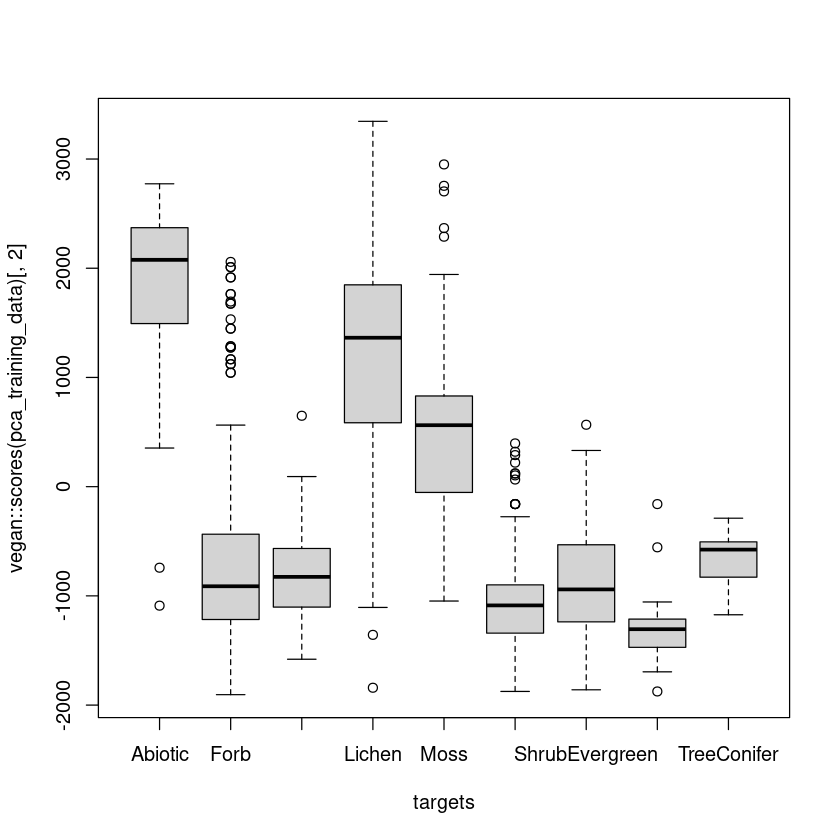

In [11]:
# fit a PCA to the ground spectra
pca_fit <- stats::prcomp(imputed_data[,1:(ncol(numeric_data) - 66)], center = FALSE, scale. = FALSE)
print(summary(pca_fit))
pca_training_data <- predict(pca_fit, imputed_data[,1:(ncol(numeric_data) - 66)])[,1:64]
boxplot(vegan::scores(pca_training_data)[,2]~targets)

## Standardization
This cell standardizes the input to center at zero with standard deviation one.

In [12]:
# standardization
indice_standardizer <- caret::preProcess(imputed_data[,1:95])
standardized_indices <- predict(indice_standardizer, imputed_data[,1:95])

val_standardizer <- caret::preProcess(validation_indices)
standardized_validation <- predict(val_standardizer, validation_indices)

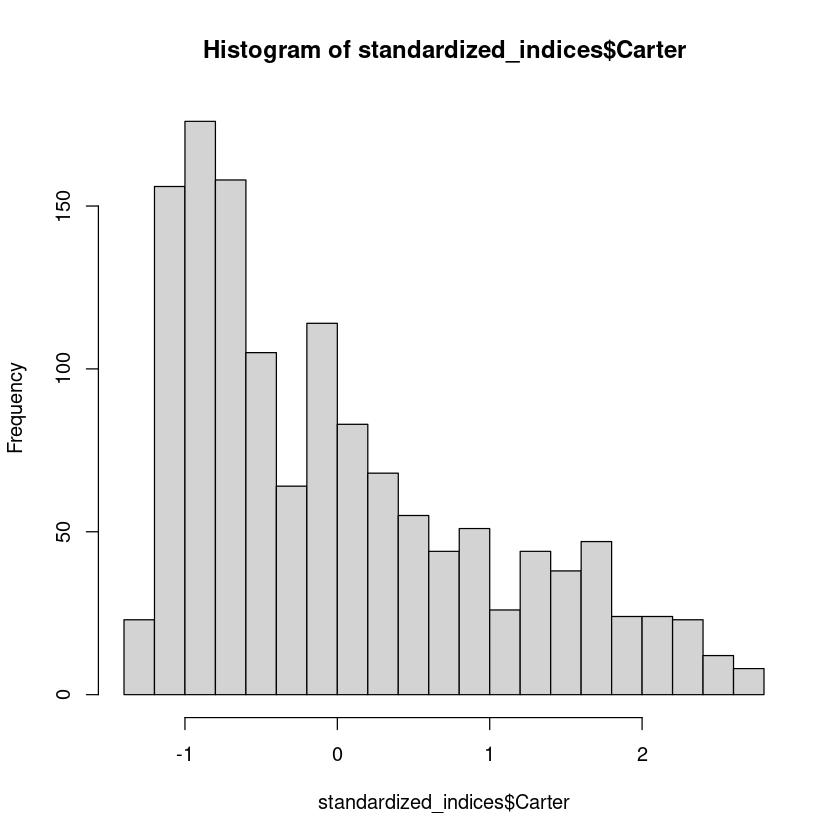

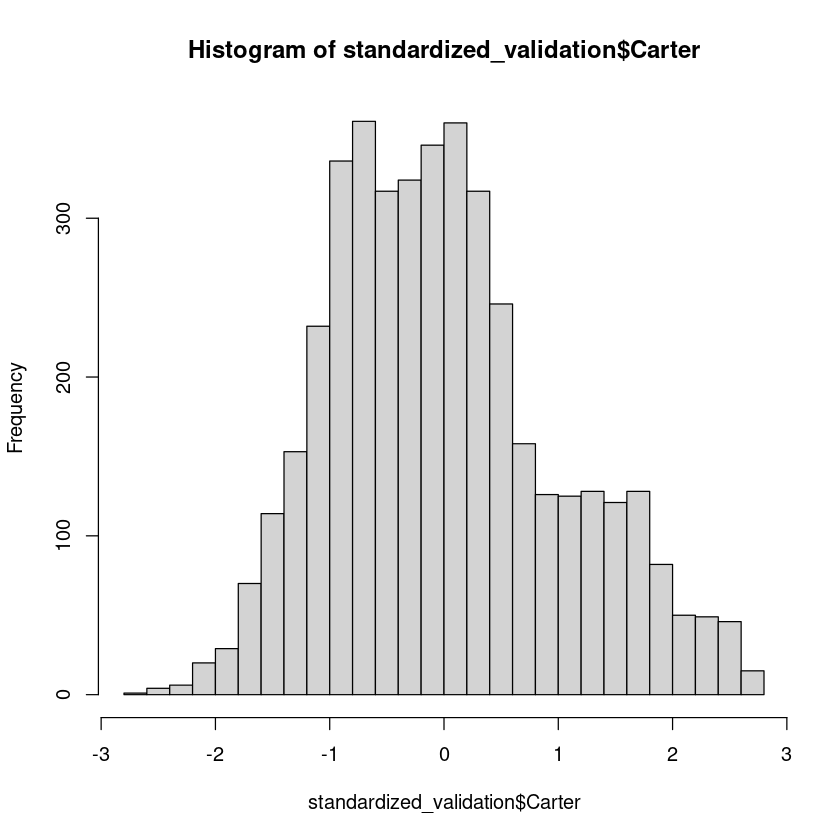

In [13]:
hist(standardized_indices$Carter, breaks = 20)
hist(standardized_validation$Carter, breaks = 20)

## Min-Max Scaling
This executes the min-man scalaing (to make the data on the scale [0,1])

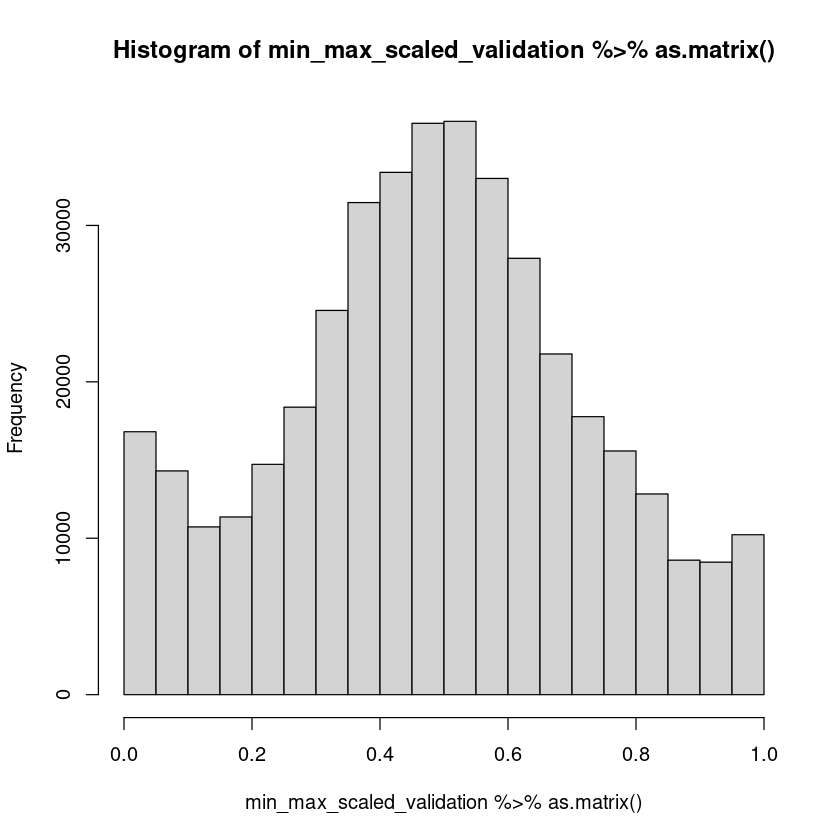

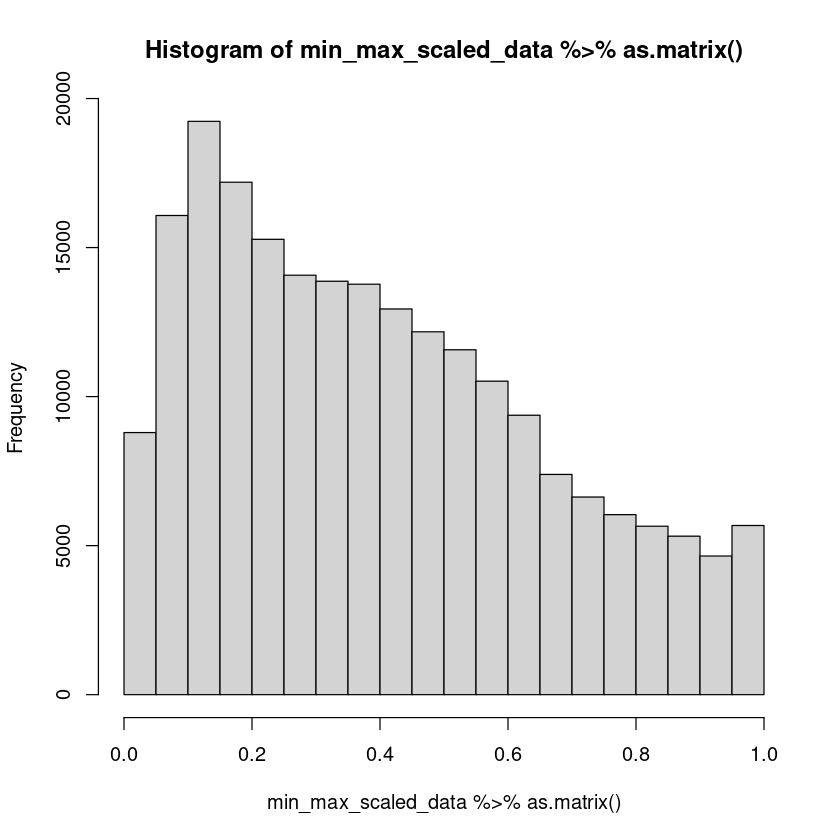

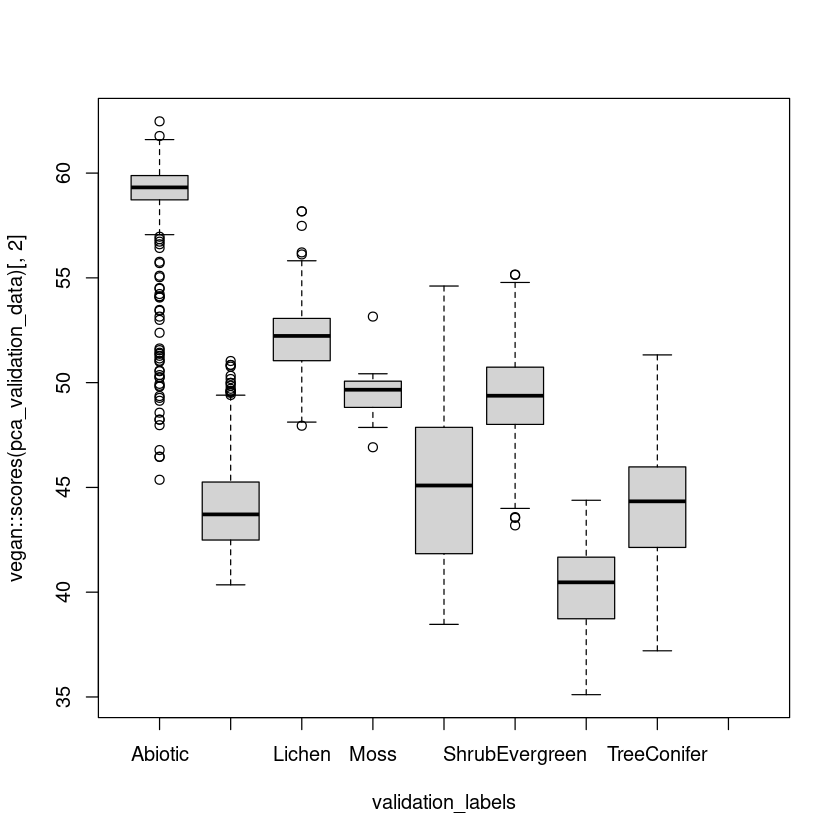

In [15]:
# plots
hist(min_max_scaled_validation %>% as.matrix())
hist(min_max_scaled_data %>% as.matrix())
pca_validation_data <- predict(pca_fit, validation_indices)[,1:64] %>% as.data.frame()
boxplot(vegan::scores(pca_validation_data)[,2]~validation_labels)

## KS Tests of Transferrability
These next few cells test whether the veg indices are similarly distributed (i.e. could be samples drawn from the same distribution)

The hypothesis is that columns (veg indices) that pass this test can safely be used across models and conditions (are transferrable)

In [ ]:
source("Functions/lecospectR.R")
ks_test_results <- test_transferrability(min_max_scaled_data, min_max_scaled_validation)
print(ks_test_results)

## t-SNE
Examine the clusters in the data via *t*-SNE

 [1] "N"                   "Y"                   "costs"              
 [4] "itercosts"           "origD"               "perplexity"         
 [7] "theta"               "max_iter"            "stop_lying_iter"    
[10] "mom_switch_iter"     "momentum"            "final_momentum"     
[13] "eta"                 "exaggeration_factor"


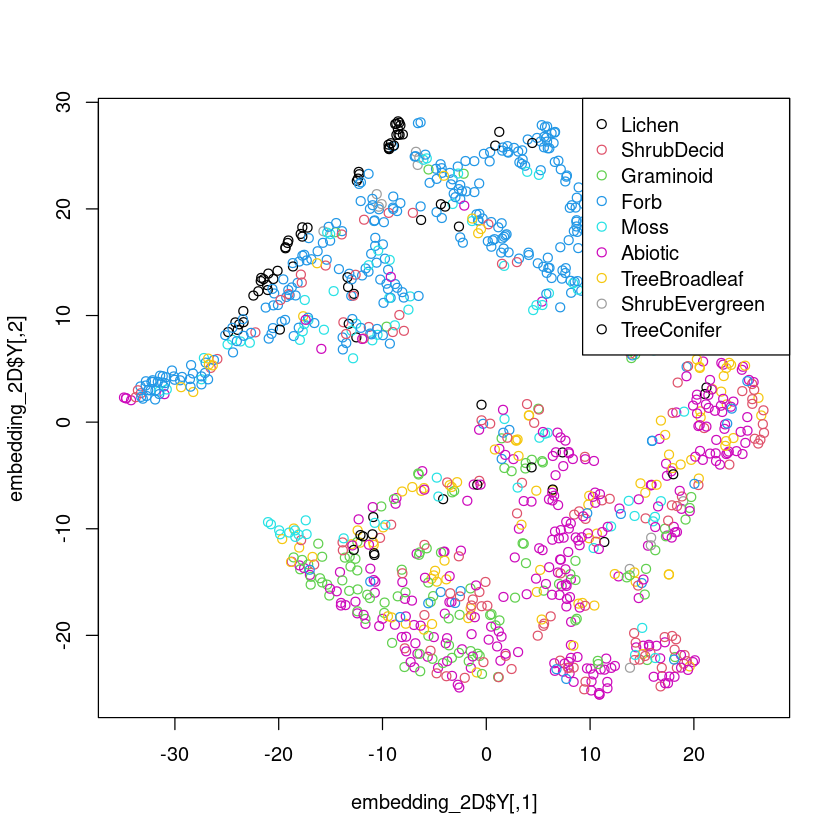

In [16]:
library(Rtsne)
unique_indices <- imputed_data[!duplicated(imputed_data),1:95]
normalized_veg_indices <- Rtsne::normalize_input(
    unique_indices %>% 
    as.matrix()
    )
embedding_2D <- Rtsne::Rtsne(normalized_veg_indices)
print(names(embedding_2D))

plot(embedding_2D$Y, col = as.factor(targets))
par(xpd=T)
legend("topright", legend = unique(targets), col = seq_along(unique(targets)),pch = 1)

## Vector Quantization Classifier
This fits a LVQ classifier to the data and then 

In [ ]:
print(length(validation_labels))
print(nrow(min_max_scaled_validation))

In [ ]:
# method 1 - transfers with 23% accuracy, which is one of the best actually
library(class)
codeBook <-  lvqinit(
    min_max_scaled_data[,1:95], 
    targets, 
10)
code_book_train <- class::olvq1(min_max_scaled_data[,1:95], targets, codeBook)
prediction <- class::lvqtest(code_book_train, min_max_scaled_data[,1:95])
lvq_conf <- caret::confusionMatrix(prediction, targets, mode = "everything")

#print(lvq_conf)

image_prediction <- class::lvqtest(code_book_train, min_max_scaled_validation)

lvq_validation_conf <- caret::confusionMatrix(image_prediction, validation_labels, mode = "everything")



In [ ]:
print(lvq_conf)

In [ ]:
print(lvq_validation_conf)

## Train-Test Split

Perform an 80-20 split on the data (use the split on the fly during the grid search)

In [ ]:
grd_train_idx <- caTools::sample.split(targets, SplitRatio = 0.8)

In [ ]:
img_train_idx <- caTools::sample.split(validation_labels, SplitRatio = 0.8)

## Random Forest
trains a random forest model

In [ ]:

rf_model <- ranger::ranger(
    num.trees = 256,
    case.weights = image_weights,
    classification = TRUE,
    x = validation_indices,
    y = validation_labels
)

print(rf_model)

In [ ]:
predictions <- predict(rf_model, validation_indices)$predictions %>% 
    as.factor()
confusion_matrix <- caret::confusionMatrix(
    predictions, 
    validation_labels, 
    mode = "everything")
print(confusion_matrix)

In [51]:
# generate the test data
permutation <- permute::shuffle(validation_labels)
val_t_chars <- validation_labels[permutation] %>% as.character()
print(val_t_chars[1:5])
counts <- c(0,0,0,0,0,0,0,0,0)
samples <- vector(mode = "logical", length=length(validation_labels))

for(i in seq_along(val_t_chars)){
    samples[[i]] <- FALSE
    if(val_t_chars[[i]] == "Abiotic"){
        if(counts[[1]]<31){
            samples[[i]] <-  TRUE
            counts[[1]] <- counts[[1]] + 1
        }

    } else if (val_t_chars[[i]] == "Graminoid"){
        if(counts[[2]] < 31){
            samples[[i]] <-  TRUE
            counts[[2]] <- counts[[2]] + 1
        }
    } else if (val_t_chars[[i]] == "Forb"){
        if(counts[[3]] < 31){
            samples[[i]] <-  TRUE
            counts[[3]] <- counts[[3]] + 1
        }
    } else if (val_t_chars[[i]] == "Lichen"){
        if(counts[[4]] < 31){
            samples[[i]] <-  TRUE
            counts[[4]] <- counts[[4]] + 1
        }
    } else if (val_t_chars[[i]] == "Moss"){
        if(counts[[5]] < 31){
            samples[[i]] <-  TRUE
            counts[[5]] <- counts[[5]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubDecid"){
        if(counts[[6]] < 31){
            samples[[i]] <-  TRUE
            counts[[6]] <- counts[[6]] + 1
        }
    } else if (val_t_chars[[i]] == "ShrubEvergreen"){
        if(counts[[7]] < 31){
            samples[[i]] <-  TRUE
            counts[[7]] <- counts[[7]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeConifer"){
        if(counts[[8]] < 31){
            samples[[i]] <-  TRUE
            counts[[8]] <- counts[[8]] + 1
        }
    } else if (val_t_chars[[i]] == "TreeBroadleaf"){
        if(counts[[9]] < 31){
            samples[[i]] <-  TRUE
            counts[[9]] <- counts[[9]] + 1
        }
    }
}


temp <- validation_labels[permutation] %>% as.factor()
test_labels <- temp[as.vector(samples)]
temp <- validation_indices[permutation,] %>% as.data.frame()
test_data <- temp[as.vector(samples),]



[1] "Graminoid"     "TreeConifer"   "TreeBroadleaf" "TreeConifer"  
[5] "TreeConifer"  


In [53]:
print(test_labels %>% table())

.
       Abiotic      Graminoid         Lichen           Moss     ShrubDecid 
            31             31             31             31             31 
ShrubEvergreen  TreeBroadleaf    TreeConifer           Forb 
            31             31             31              0 


# Grid Search

This next section defines all the essentials for the grid search across our different candidate models. 

## Candidates

### Models
* Random Forest
* Learned Vector Quantization (LVQ)
* k-Nearest Neighbor (kNN)

Could also consider Support Vector Machine (SVM), Gradient Boosted Trees (e.g. LightGBM, XGBoost), matched filtering, Logistic Regression, etc.

### Data/Transformations

For each of the image/training data sets, test the following:
* raw, 
* raw (no outliers)
* standardized (z-score standardization)
* standardized (z-score standardization, no outliers)
* min-max scaled
* min-max scaled (no outliers)
* PCA
* PCA no outliers

Need to also vary how many columns are included in the analysis

In [58]:
# define the data sets to loop over
gs_train <- list(
    standardized_indices[,1:95],
    standardized_indices,
    min_max_scaled_data[,1:95],
    min_max_scaled_data,
    min_max_scaled_validation,
    standardized_validation
    #pca_training_data,
    #pca_validation_data[img_train_idx,]
)

gs_test <- list(
    standardized_validation[permutation,][samples,],
    standardized_validation[permutation,][samples,],
    min_max_scaled_validation[permutation,][samples,],
    min_max_scaled_validation[permutation,][samples,]
    #pca_validation_data[-img_train_idx],
    #pca_validation_data[-img_train_idx]

)

gs_train_labels <- list(
    targets,
    targets,
    targets,
    targets,
    targets,
    targets
)

gs_samples <- list(
    test_labels,
    test_labels,
    test_labels,
    test_labels
)

In [60]:
gs_methods <- list(
    #"svmLinear",
    #"rmda",
    "RFlda",
    "svmRadialWeights",
    "mda",
    "knn",
    "lda",
    "ranger",
    "hda"# heteroscedastic discriminant analysis
)
# add: PLS-LDA, kNN, SVM+poly Kernel, SVM+Exp Kernel, more boosting, 

In [61]:
gs_weight_text <- c(
    "prior weights",
    NULL
)

gs_weights <- list(
    weights_by_pft,
    image_weights,
    weights_by_pft,
    image_weights,
    weights_by_pft,
    image_weights
)

fit_ctrl <- caret::trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 3,
    classProbs = TRUE,
    allowParallel = TRUE
)

In [65]:
for(i in seq_along(gs_train)){
    for(j in seq_along(gs_methods)){
        # train and print intermediate results to console
        df <- data.frame(gs_train[[i]])
        df$targets <-  as.factor(gs_train_labels[[i]]) 
        print("Beginning Training")
        model <- train(
           targets ~ ., 
            data = df,
            method = gs_methods[[j]],
            trControl = fit_ctrl,
            weights = gs_weights[[i]]
        )
        print(model)

        model_predictions <- predict(
            model, 
            gs_test[[i]]
        ) %>% as.factor()
        
        samples <- gs_samples[[i]] %>% as.factor()
        levels(samples) <- c(levels(samples), "Forb")

        confusion_matrix <- caret::confusionMatrix(
            model_predictions, 
            samples,
            mode = "everything"
        )

        model_id <- uuid::UUIDgenerate()

        # append performance data to the logs for later comparison
        sink(file = "mle/log1.txt", append = TRUE)
        print("-------------------------------------------------------")
        print("---------------------- Model Data ---------------------")
        
        print(paste0("Model Type: ", gs_methods[[j]]))
        print(paste0("Data Index: ",i))
        print(paste0("Model UUID: ", model_id))
        print("---------------------- Confusion Matrix ---------------------")
        print(confusion_matrix)
        print("\n")
        print("---------------------- Class Distribution ---------------------")
        print(model_predictions %>% as.factor() %>% table())
        print("-------------------------------------------------------")
        print("\n\n")
        sink(NULL)

        
        save(model, file = paste0("mle/models/gs/", model_id, ".rda"))

    }
}

[1] "Beginning Training"


Warning message in train.default(x, y, weights = w, ...):
“Class probabilities were requested for a model that does not implement them”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in v/sqrt(v %*% RightMult(A, v)):
“Recycling array of length 1 

Factor-Based Linear Discriminant Analysis 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1209, 1208, 1207, 1208, 1209, 1209, ... 
Resampling results across tuning parameters:

  q  Accuracy   Kappa    
  1  0.5536764  0.4614675
  2  0.5665623  0.4760400
  3  0.5983305  0.5088462

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was q = 3.


Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"


Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01346, C=0.25, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01346, C=0.50, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01346, C=1.00, Weight=2 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01346, C=0.25, Weight=3 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.01346, C=0.50, Weight=3 Error in names(wts) <- levels(y) : 
  'names' attribute [9] must be the same length as the vector [2]
”
Warning message:
“model fit failed for Fold01.Rep1: sigma=0.

Support Vector Machines with Class Weights 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1209, 1209, 1211, 1207, 1208, 1206, ... 
Resampling results across tuning parameters:

  C     Weight  Accuracy   Kappa    
  0.25  1       0.6947878  0.6074544
  0.25  2             NaN        NaN
  0.25  3             NaN        NaN
  0.50  1       0.7329686  0.6608191
  0.50  2             NaN        NaN
  0.50  3             NaN        NaN
  1.00  1       0.7766072  0.7184951
  1.00  2             NaN        NaN
  1.00  3             NaN        NaN

Tuning parameter 'sigma' was held constant at a value of 0.01345953
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.01345953, C = 1 and Weight
 = 1.


Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Mixture Discriminant Analysis 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1208, 1211, 1208, 1209, 1209, 1206, ... 
Resampling results across tuning parameters:

  subclasses  Accuracy   Kappa    
  2           0.7967780  0.7502223
  3           0.7955107  0.7502295
  4           0.8021226  0.7593328

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was subclasses = 4.


Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
k-Nearest Neighbors 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1208, 1210, 1210, 1208, 1208, 1209, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8074274  0.7603439
  7  0.7964647  0.7461359
  9  0.7816089  0.7272349

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.


Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Linear Discriminant Analysis 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1209, 1208, 1207, 1209, 1211, 1207, ... 
Resampling results:

  Accuracy   Kappa    
  0.7866763  0.7354403



Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Random Forest 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1210, 1210, 1210, 1207, 1209, 1208, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
   2    gini        0.8090806  0.7684897
   2    extratrees  0.8085882  0.7680013
  48    gini        0.8207208  0.7825650
  48    extratrees  0.8368843  0.8022062
  95    gini        0.8112653  0.7712884
  95    extratrees  0.8391121  0.8049061

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 95, splitrule = extratrees
 and min.node.size = 1.


Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"
Initialization by the identity.
Iteration 1 Log Likelihood:  -124589.897524507 
Iteration 2 Log Likelihood:  -122412.808353383 
Iteration 3 Log Likelihood:  -122412.808353383 
Iteration 4 Log Likelihood:  -122412.808353383 
Iteration 5 Log Likelihood:  -122412.808353383 
Iteration 6 Log Likelihood:  -122412.808353383 
Iteration 7 Log Likelihood:  -122412.808353383 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123356.16472322 
Iteration 2 Log Likelihood:  -95758.7113874893 
Iteration 3 Log Likelihood:  -95758.7113874893 
Iteration 4 Log Likelihood:  -95758.7113874892 
Iteration 5 Log Likelihood:  -95758.7113874892 
Iteration 6 Log Likelihood:  -95758.7113874893 
Iteration 7 Log Likelihood:  -95758.7113874892 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120196.536698864 
Iteration 2 Log Likelihood:  95303.1568313436 
Iteration 3 Log Likelihood:  95303.1568313811 
Iteration 4 Log Likelihood:  95303.1568313232 
Iteration 5 Log Likelihood:  95303.1568313907 
Iteration 6 Log Likelihood:  95303.1568313223 
Iteration 7 Log Likelihood:  95303.1568313425 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124903.287580842 
Iteration 2 Log Likelihood:  -122723.502422198 
Iteration 3 Log Likelihood:  -122723.502257504 
Iteration 4 Log Likelihood:  -122723.50209246 
Iteration 5 Log Likelihood:  -122723.501927042 
Iteration 6 Log Likelihood:  -122723.501761241 
Iteration 7 Log Likelihood:  -122723.501595047 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123624.401344071 
Iteration 2 Log Likelihood:  -96027.4705511877 
Iteration 3 Log Likelihood:  -96027.4694945286 
Iteration 4 Log Likelihood:  -96027.468438343 
Iteration 5 Log Likelihood:  -96027.4673781095 
Iteration 6 Log Likelihood:  -96027.4663137489 
Iteration 7 Log Likelihood:  -96027.4652451748 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120350.995050191 
Iteration 2 Log Likelihood:  95510.5214524721 
Iteration 3 Log Likelihood:  95513.6929978053 
Iteration 4 Log Likelihood:  95516.5928154782 
Iteration 5 Log Likelihood:  95518.9324790473

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123356.16472322 
Iteration 2 Log Likelihood:  -95758.7113874892 
Iteration 3 Log Likelihood:  -95758.7113874892 
Iteration 4 Log Likelihood:  -95758.7113874892 
Iteration 5 Log Likelihood:  -95758.7113874892 
Iteration 6 Log Likelihood:  -95758.7113874892 
Iteration 7 Log Likelihood:  -95758.7113874892 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120196.536698864 
Iteration 2 Log Likelihood:  95303.1568313962 
Iteration 3 Log Likelihood:  95303.1568313221 
Iteration 4 Log Likelihood:  95303.1568312936 
Iteration 5 Log Likelihood:  95303.1568313665 
Iteration 6 Log Likelihood:  95303.1568313275 
Iteration 7 Log Likelihood:  95303.1568313526 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124903.098323276 
Iteration 2 Log Likelihood:  -122723.383476447 
Iteration 3 Log Likelihood:  -122723.383213199 
Iteration 4 Log Likelihood:  -122723.38294848 
Iteration 5 Log Likelihood:  -122723.382682186 
Iteration 6 Log Likelihood:  -122723.382414272 
Iteration 7 Log Likelihood:  -122723.382144697 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123623.20065046 
Iteration 2 Log Likelihood:  -96027.3651204971 
Iteration 3 Log Likelihood:  -96027.3628866398 
Iteration 4 Log Likelihood:  -96027.3606031333 
Iteration 5 Log Likelihood:  -96027.3582616801 
Iteration 6 Log Likelihood:  -96027.355858611 
Iteration 7 Log Likelihood:  -96027.353389945 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120348.60007239 
Iteration 2 Log Likelihood:  95511.2467179095 
Iteration 3 Log Likelihood:  95514.8637151601 
Iteration 4 Log Likelihood:  95518.5698955897 
Iteration 5 Log Likelihood:  95522.2054566974 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123978.628534879 
Iteration 2 Log Likelihood:  -96176.6434183347 
Iteration 3 Log Likelihood:  -96176.6434183347 
Iteration 4 Log Likelihood:  -96176.6434183347 
Iteration 5 Log Likelihood:  -96176.6434183347 
Iteration 6 Log Likelihood:  -96176.6434183347 
Iteration 7 Log Likelihood:  -96176.6434183346 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120920.89962305 
Iteration 2 Log Likelihood:  103430.942319783 
Iteration 3 Log Likelihood:  103430.942319579 
Iteration 4 Log Likelihood:  103430.942319411 
Iteration 5 Log Likelihood:  103430.942319169 
Iteration 6 Log Likelihood:  103430.942319422 
Iteration 7 Log Likelihood:  103430.942319381 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125451.910035057 
Iteration 2 Log Likelihood:  -123250.211414617 
Iteration 3 Log Likelihood:  -123250.211308677 
Iteration 4 Log Likelihood:  -123250.211202192 
Iteration 5 Log Likelihood:  -123250.21109514 
Iteration 6 Log Likelihood:  -123250.210987511 
Iteration 7 Log Likelihood:  -123250.210879297 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124209.173554861 
Iteration 2 Log Likelihood:  -96411.1062048252 
Iteration 3 Log Likelihood:  -96411.1055048063 
Iteration 4 Log Likelihood:  -96411.104806013 
Iteration 5 Log Likelihood:  -96411.1041033382 
Iteration 6 Log Likelihood:  -96411.1033966397 
Iteration 7 Log Likelihood:  -96411.1026857698 
Initialization by the identity.
Iteration 1 Log Likelihood:  -121039.64887685 
Iteration 2 Log Likelihood:  103601.294119091 
Iteration 3 Log Likelihood:  103604.398895433 
Iteration 4 Log Likelihood:  103607.12761355 
Iteration 5 Log Likelihood:  103609.2470117 
It

Warning message:
“model fit failed for Fold02.Rep1: gamma=1.00, lambda=1.0, newdim=2 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 5.77063e-17
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125176.905514706 
Iteration 2 Log Likelihood:  -122977.325168597 
Iteration 3 Log Likelihood:  -122977.325168597 
Iteration 4 Log Likelihood:  -122977.325168597 
Iteration 5 Log Likelihood:  -122977.325168597 
Iteration 6 Log Likelihood:  -122977.325168597 
Iteration 7 Log Likelihood:  -122977.325168597 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123978.628534879 
Iteration 2 Log Likelihood:  -96176.6434183347 
Iteration 3 Log Likelihood:  -96176.6434183347 
Iteration 4 Log Likelihood:  -96176.6434183347 
Iteration 5 Log Likelihood:  -96176.6434183347 
Iteration 6 Log Likelihood:  -96176.6434183347 
Iteration 7 Log Likelihood:  -96176.6434183347 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120920.89962305 
Iteration 2 Log Likelihood:  103430.942319724 
Iteration 3 Log Likelihood:  103430.942319096 
Iteration 4 Log Likelihood:  103430.942319689 
Iteration 5 Log Likelihood:  103430.942319762 
Iteration 6 Log Likelihood:  103430.942320213 
Iteration 7 Log Likelihood:  103430.942319508 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125451.754152032 
Iteration 2 Log Likelihood:  -123250.111397209 
Iteration 3 Log Likelihood:  -123250.111240736 
Iteration 4 Log Likelihood:  -123250.111083344 
Iteration 5 Log Likelihood:  -123250.110924958 
Iteration 6 Log Likelihood:  -123250.110765558 
Iteration 7 Log Likelihood:  -123250.110605127 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124208.08301951 
Iteration 2 Log Likelihood:  -96411.0089052904 
Iteration 3 Log Likelihood:  -96411.0070586857 
Iteration 4 Log Likelihood:  -96411.0051603562 
Iteration 5 Log Likelihood:  -96411.0032003309 
Iteration 6 Log Likelihood:  -96411.0011745081 
Iteration 7 Log Likelihood:  -96410.9990784436 
Initialization by the identity.
Iteration 1 Log Likelihood:  -121037.429199565 
Iteration 2 Log Likelihood:  103602.134886741 
Iteration 3 Log Likelihood:  103605.809079449 
Iteration 4 Log Likelihood:  103609.53734418 
Iteration 5 Log Likelihood:  103613.192371369

Warning message:
“model fit failed for Fold02.Rep1: gamma=1.00, lambda=1.0, newdim=3 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 5.97502e-17
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123994.680744696 
Iteration 2 Log Likelihood:  -121821.801943206 
Iteration 3 Log Likelihood:  -121821.801943206 
Iteration 4 Log Likelihood:  -121821.801943206 
Iteration 5 Log Likelihood:  -121821.801943206 
Iteration 6 Log Likelihood:  -121821.801943206 
Iteration 7 Log Likelihood:  -121821.801943206 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122736.84062211 
Iteration 2 Log Likelihood:  -95166.6169716187 
Iteration 3 Log Likelihood:  -95166.6169716188 
Iteration 4 Log Likelihood:  -95166.6169716188 
Iteration 5 Log Likelihood:  -95166.6169716188 
Iteration 6 Log Likelihood:  -95166.6169716187 
Iteration 7 Log Likelihood:  -95166.6169716187 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119533.368478473 
Iteration 2 Log Likelihood:  96887.3397057136 
Iteration 3 Log Likelihood:  96887.3397057195 
Iteration 4 Log Likelihood:  96887.3397057332 
Iteration 5 Log Likelihood:  96887.3397057215 
Iteration 6 Log Likelihood:  96887.339705737 
Iteration 7 Log Likelihood:  96887.3397057309 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124272.458165633 
Iteration 2 Log Likelihood:  -122097.322893763 
Iteration 3 Log Likelihood:  -122097.322760407 
Iteration 4 Log Likelihood:  -122097.322626863 
Iteration 5 Log Likelihood:  -122097.322493116 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122736.84062211 
Iteration 2 Log Likelihood:  -95166.6169716188 
Iteration 3 Log Likelihood:  -95166.6169716188 
Iteration 4 Log Likelihood:  -95166.6169716187 
Iteration 5 Log Likelihood:  -95166.6169716187 
Iteration 6 Log Likelihood:  -95166.6169716187 
Iteration 7 Log Likelihood:  -95166.6169716187 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119533.368478473 
Iteration 2 Log Likelihood:  96887.3397057188 
Iteration 3 Log Likelihood:  96887.3397057372 
Iteration 4 Log Likelihood:  96887.3397057666 
Iteration 5 Log Likelihood:  96887.339705699 
Iteration 6 Log Likelihood:  96887.3397057286 
Iteration 7 Log Likelihood:  96887.3397057175 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124272.283409273 
Iteration 2 Log Likelihood:  -122097.219269292 
Iteration 3 Log Likelihood:  -122097.219047428 
Iteration 4 Log Likelihood:  -122097.218824258 
Iteration 5 Log Likelihood:  -122097.218599683 
Iteration 6 Log Likelihood:  -122097.218373666 
Iteration 7 Log Likelihood:  -122097.218146172 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122968.338615467 
Iteration 2 Log Likelihood:  -95403.6482416392 
Iteration 3 Log Likelihood:  -95403.6459894606 
Iteration 4 Log Likelihood:  -95403.643671992 
Iteration 5 Log Likelihood:  -95403.6412794812 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124724.129017643 
Iteration 2 Log Likelihood:  -122542.531475484 
Iteration 3 Log Likelihood:  -122542.53136654 
Iteration 4 Log Likelihood:  -122542.531256532 
Iteration 5 Log Likelihood:  -122542.531145424 
Iteration 6 Log Likelihood:  -122542.531033198 
Iteration 7 Log Likelihood:  -122542.530919835 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123466.694539361 
Iteration 2 Log Likelihood:  -95814.4314344362 
Iteration 3 Log Likelihood:  -95814.4307597174 
Iteration 4 Log Likelihood:  -95814.4300824624 
Iteration 5 Log Likelihood:  -95814.4293981407 
Iteration 6 Log Likelihood:  -95814.4287064922 
Iteration 7 Log Likelihood:  -95814.4280072471 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120274.672955377 
Iteration 2 Log Likelihood:  95695.1248855932 
Iteration 3 Log Likelihood:  95697.9504370662 
Iteration 4 Log Likelihood:  95700.4422427277 
Iteration 5 Log Likelihood:  95702.375821461

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123265.38903819 
Iteration 2 Log Likelihood:  -95603.3521459417 
Iteration 3 Log Likelihood:  -95603.3521459418 
Iteration 4 Log Likelihood:  -95603.3521459417 
Iteration 5 Log Likelihood:  -95603.3521459418 
Iteration 6 Log Likelihood:  -95603.3521459417 
Iteration 7 Log Likelihood:  -95603.3521459418 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120189.595337834 
Iteration 2 Log Likelihood:  95507.6641523706 
Iteration 3 Log Likelihood:  95507.6641523506 
Iteration 4 Log Likelihood:  95507.6641523443 
Iteration 5 Log Likelihood:  95507.6641523242 
Iteration 6 Log Likelihood:  95507.6641523402 
Iteration 7 Log Likelihood:  95507.6641523209 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124723.989092987 
Iteration 2 Log Likelihood:  -122542.438227471 
Iteration 3 Log Likelihood:  -122542.438090544 
Iteration 4 Log Likelihood:  -122542.437952508 
Iteration 5 Log Likelihood:  -122542.437813264 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122620.068281082 
Iteration 2 Log Likelihood:  -94992.5772993879 
Iteration 3 Log Likelihood:  -94992.5772993879 
Iteration 4 Log Likelihood:  -94992.5772993879 
Iteration 5 Log Likelihood:  -94992.5772993879 
Iteration 6 Log Likelihood:  -94992.5772993879 
Iteration 7 Log Likelihood:  -94992.5772993879 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119404.953077075 
Iteration 2 Log Likelihood:  96495.4889775277 
Iteration 3 Log Likelihood:  96495.4889775319 
Iteration 4 Log Likelihood:  96495.4889775203 
Iteration 5 Log Likelihood:  96495.4889775149 
Iteration 6 Log Likelihood:  96495.4889775194 
Iteration 7 Log Likelihood:  96495.4889775037 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124130.990836004 
Iteration 2 Log Likelihood:  -121949.681566244 
Iteration 3 Log Likelihood:  -121949.681427325 
Iteration 4 Log Likelihood:  -121949.681288053 
Iteration 5 Log Likelihood:  -121949.681148406 
Iteration 6 Log Likelihood:  -121949.681008379 
Iteration 7 Log Likelihood:  -121949.680867963 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122833.714028705 
Iteration 2 Log Likelihood:  -95217.5926695314 
Iteration 3 Log Likelihood:  -95217.5918195504 
Iteration 4 Log Likelihood:  -95217.5909698198 
Iteration 5 Log Likelihood:  -95217.5901151101 
Iteration 6 Log Likelihood:  -95217.5892553042 
Iteration 7 Log Likelihood:  -95217.5883902798 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119499.167413682 
Iteration 2 Log Likelihood:  96632.7770515363 
Iteration 3 Log Likelihood:  96636.1106420057 
Iteration 4 Log Likelihood:  96638.9902557845 
Iteration 5 Log Likelihood:  96641.17503532

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122620.068281082 
Iteration 2 Log Likelihood:  -94992.577299388 
Iteration 3 Log Likelihood:  -94992.5772993879 
Iteration 4 Log Likelihood:  -94992.577299388 
Iteration 5 Log Likelihood:  -94992.577299388 
Iteration 6 Log Likelihood:  -94992.577299388 
Iteration 7 Log Likelihood:  -94992.577299388 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119404.953077075 
Iteration 2 Log Likelihood:  96495.4889775085 
Iteration 3 Log Likelihood:  96495.4889775221 
Iteration 4 Log Likelihood:  96495.4889774988 
Iteration 5 Log Likelihood:  96495.4889774917 
Iteration 6 Log Likelihood:  96495.4889774822 
Iteration 7 Log Likelihood:  96495.4889774927 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124130.8238386 
Iteration 2 Log Likelihood:  -121949.580444046 
Iteration 3 Log Likelihood:  -121949.580224737 
Iteration 4 Log Likelihood:  -121949.580004111 
Iteration 5 Log Likelihood:  -121949.579782061 
Itera

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123680.778471656 
Iteration 2 Log Likelihood:  -95964.627503103 
Iteration 3 Log Likelihood:  -95964.627503103 
Iteration 4 Log Likelihood:  -95964.627503103 
Iteration 5 Log Likelihood:  -95964.6275031031 
Iteration 6 Log Likelihood:  -95964.627503103 
Iteration 7 Log Likelihood:  -95964.627503103 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120558.269651578 
Iteration 2 Log Likelihood:  95149.2331605786 
Iteration 3 Log Likelihood:  95149.2331605373 
Iteration 4 Log Likelihood:  95149.233160546 
Iteration 5 Log Likelihood:  95149.2331605601 
Iteration 6 Log Likelihood:  95149.2331605395 
Iteration 7 Log Likelihood:  95149.2331605645 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125168.700900187 
Iteration 2 Log Likelihood:  -122977.439805728 
Iteration 3 Log Likelihood:  -122977.43951862 
Iteration 4 Log Likelihood:  -122977.439230257 
Iteration 5 Log Likelihood:  -122977.438940541 
Iteration 6 Log Likelihood:  -122977.438649431 
Iteration 7 Log Likelihood:  -122977.438356885 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123893.394536537 
Iteration 2 Log Likelihood:  -96184.3770732536 
Iteration 3 Log Likelihood:  -96184.3744118663 
Iteration 4 Log Likelihood:  -96184.3716772819 
Iteration 5 Log Likelihood:  -96184.3688596588 
Iteration 6 Log Likelihood:  -96184.3659536735 
Iteration 7 Log Likelihood:  -96184.3629535464 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120643.840004805 
Iteration 2 Log Likelihood:  95361.1650301481 
Iteration 3 Log Likelihood:  95364.6321045254 
Iteration 4 Log Likelihood:  95368.1421870309 
Iteration 5 Log Likelihood:  95371.575689268

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123162.116695798 
Iteration 2 Log Likelihood:  -95567.3414484129 
Iteration 3 Log Likelihood:  -95567.3414484129 
Iteration 4 Log Likelihood:  -95567.3414484129 
Iteration 5 Log Likelihood:  -95567.3414484129 
Iteration 6 Log Likelihood:  -95567.3414484129 
Iteration 7 Log Likelihood:  -95567.3414484129 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119827.931078404 
Iteration 2 Log Likelihood:  96135.6619835592 
Iteration 3 Log Likelihood:  96135.6619835427 
Iteration 4 Log Likelihood:  96135.661983579 
Iteration 5 Log Likelihood:  96135.6619835696 
Iteration 6 Log Likelihood:  96135.6619835532 
Iteration 7 Log Likelihood:  96135.6619835762 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124709.706066307 
Iteration 2 Log Likelihood:  -122523.232919116 
Iteration 3 Log Likelihood:  -122523.232707187 
Iteration 4 Log Likelihood:  -122523.232495529 
Iteration 5 Log Likelihood:  -122523.232284117 
Iteration 6 Log Likelihood:  -122523.232072939 
Iteration 7 Log Likelihood:  -122523.231861981 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123365.408282778 
Iteration 2 Log Likelihood:  -95779.6894628149 
Iteration 3 Log Likelihood:  -95779.6882706803 
Iteration 4 Log Likelihood:  -95779.687080253 
Iteration 5 Log Likelihood:  -95779.685887143 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123162.116695798 
Iteration 2 Log Likelihood:  -95567.3414484129 
Iteration 3 Log Likelihood:  -95567.3414484129 
Iteration 4 Log Likelihood:  -95567.3414484128 
Iteration 5 Log Likelihood:  -95567.3414484129 
Iteration 6 Log Likelihood:  -95567.3414484129 
Iteration 7 Log Likelihood:  -95567.3414484128 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119827.931078404 
Iteration 2 Log Likelihood:  96135.6619835471 
Iteration 3 Log Likelihood:  96135.661983572 
Iteration 4 Log Likelihood:  96135.6619835648 
Iteration 5 Log Likelihood:  96135.6619835805 
Iteration 6 Log Likelihood:  96135.6619835484 
Iteration 7 Log Likelihood:  96135.661983545 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124709.506938081 
Iteration 2 Log Likelihood:  -122523.113204304 
Iteration 3 Log Likelihood:  -122523.112851682 
Iteration 4 Log Likelihood:  -122523.112497139 
Iteration 5 Log Likelihood:  -122523.11214053 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123469.270821877 
Iteration 2 Log Likelihood:  -95840.5420698031 
Iteration 3 Log Likelihood:  -95840.5420698031 
Iteration 4 Log Likelihood:  -95840.5420698031 
Iteration 5 Log Likelihood:  -95840.5420698031 
Iteration 6 Log Likelihood:  -95840.5420698031 
Iteration 7 Log Likelihood:  -95840.5420698031 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120378.840093407 
Iteration 2 Log Likelihood:  94263.6333700766 
Iteration 3 Log Likelihood:  94263.6333700703 
Iteration 4 Log Likelihood:  94263.6333700927 
Iteration 5 Log Likelihood:  94263.6333700855 
Iteration 6 Log Likelihood:  94263.6333701092 
Iteration 7 Log Likelihood:  94263.6333700975 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124929.115838075 
Iteration 2 Log Likelihood:  -122746.030518683 
Iteration 3 Log Likelihood:  -122746.030399491 
Iteration 4 Log Likelihood:  -122746.030279395 
Iteration 5 Log Likelihood:  -122746.030158371 
Iteration 6 Log Likelihood:  -122746.030036404 
Iteration 7 Log Likelihood:  -122746.02991348 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123671.238099885 
Iteration 2 Log Likelihood:  -96049.2685530758 
Iteration 3 Log Likelihood:  -96049.2678025294 
Iteration 4 Log Likelihood:  -96049.2670505177 
Iteration 5 Log Likelihood:  -96049.2662922979 
Iteration 6 Log Likelihood:  -96049.2655276785 
Iteration 7 Log Likelihood:  -96049.2647564611 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120465.92719043 
Iteration 2 Log Likelihood:  94439.6467316951 
Iteration 3 Log Likelihood:  94442.6146849339 
Iteration 4 Log Likelihood:  94445.3371341243 
Iteration 5 Log Likelihood:  94447.5530747436

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123469.270821877 
Iteration 2 Log Likelihood:  -95840.5420698031 
Iteration 3 Log Likelihood:  -95840.5420698031 
Iteration 4 Log Likelihood:  -95840.5420698031 
Iteration 5 Log Likelihood:  -95840.5420698031 
Iteration 6 Log Likelihood:  -95840.5420698031 
Iteration 7 Log Likelihood:  -95840.5420698031 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120378.840093407 
Iteration 2 Log Likelihood:  94263.6333700888 
Iteration 3 Log Likelihood:  94263.6333700885 
Iteration 4 Log Likelihood:  94263.6333700842 
Iteration 5 Log Likelihood:  94263.6333700732 
Iteration 6 Log Likelihood:  94263.6333700932 
Iteration 7 Log Likelihood:  94263.6333700729 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124928.954464627 
Iteration 2 Log Likelihood:  -122745.927377024 
Iteration 3 Log Likelihood:  -122745.927216169 
Iteration 4 Log Likelihood:  -122745.92705412 
Iteration 5 Log Likelihood:  -122745.9268908 
Iteration 6 Log Likelihood:  -122745.926726188 
Iteration 7 Log Likelihood:  -122745.926560263 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123670.056218426 
Iteration 2 Log Likelihood:  -96049.1664026389 
Iteration 3 Log Likelihood:  -96049.1644911359 
Iteration 4 Log Likelihood:  -96049.1625193523 
Iteration 5 Log Likelihood:  -96049.1604774375 
Iteration 6 Log Likelihood:  -96049.1583604551 
Iteration 7 Log Likelihood:  -96049.1561630278 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120463.527975117 
Iteration 2 Log Likelihood:  94440.6457467891 
Iteration 3 Log Likelihood:  94444.4158440273 
Iteration 4 Log Likelihood:  94448.7083829821 
Iteration 5 Log Likelihood:  94453.5029461412 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119416.201229531 
Iteration 2 Log Likelihood:  95945.1410623925 
Iteration 3 Log Likelihood:  95945.1410624332 
Iteration 4 Log Likelihood:  95945.1410624137 
Iteration 5 Log Likelihood:  95945.1410624374 
Iteration 6 Log Likelihood:  95945.1410624475 
Iteration 7 Log Likelihood:  95945.1410624649 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124264.224142264 
Iteration 2 Log Likelihood:  -122093.262575538 
Iteration 3 Log Likelihood:  -122093.262468522 
Iteration 4 Log Likelihood:  -122093.262361365 
Iteration 5 Log Likelihood:  -122093.262254051 
Iteration 6 Log Likelihood:  -122093.262146575 
Iteration 7 Log Likelihood:  -122093.262038933 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122948.563977003 
Iteration 2 Log Likelihood:  -95397.1177205178 
Iteration 3 Log Likelihood:  -95397.1169382152 
Iteration 4 Log Likelihood:  -95397.1161580094 
Iteration 5 Log Likelihood:  -95397.1153753901

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124264.036175972 
Iteration 2 Log Likelihood:  -122093.153842937 
Iteration 3 Log Likelihood:  -122093.153624566 
Iteration 4 Log Likelihood:  -122093.153404413 
Iteration 5 Log Likelihood:  -122093.153182344 
Iteration 6 Log Likelihood:  -122093.152958303 
Iteration 7 Log Likelihood:  -122093.152732234 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122947.321315196 
Iteration 2 Log Likelihood:  -95397.0127312148 
Iteration 3 Log Likelihood:  -95397.0106294047 
Iteration 4 Log Likelihood:  -95397.0084673834 
Iteration 5 Log Likelihood:  -95397.0062348571 
Iteration 6 Log Likelihood:  -95397.0039270852 
Iteration 7 Log Likelihood:  -95397.0015389243 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119582.747924243 
Iteration 2 Log Likelihood:  96067.3591855262 
Iteration 3 Log Likelihood:  96070.6588371889 
Iteration 4 Log Likelihood:  96074.331060867 
Iteration 5 Log Likelihood:  96078.094573964

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119646.999039944 
Iteration 2 Log Likelihood:  95668.696187498 
Iteration 3 Log Likelihood:  95668.6961874902 
Iteration 4 Log Likelihood:  95668.6961875029 
Iteration 5 Log Likelihood:  95668.6961875008 
Iteration 6 Log Likelihood:  95668.6961874861 
Iteration 7 Log Likelihood:  95668.6961874926 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124150.977750352 
Iteration 2 Log Likelihood:  -121962.05643992 
Iteration 3 Log Likelihood:  -121962.056306062 
Iteration 4 Log Likelihood:  -121962.05617029 
Iteration 5 Log Likelihood:  -121962.056032544 
Iteration 6 Log Likelihood:  -121962.055892781 
Iteration 7 Log Likelihood:  -121962.055750951 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122893.746179254 
Iteration 2 Log Likelihood:  -95238.1247050856 
Iteration 3 Log Likelihood:  -95238.1239226544 
Iteration 4 Log Likelihood:  -95238.1231316797 
Iteration 5 Log Likelihood:  -95238.1223280793 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122734.565555221 
Iteration 2 Log Likelihood:  -95068.8068214867 
Iteration 3 Log Likelihood:  -95068.8068214867 
Iteration 4 Log Likelihood:  -95068.8068214867 
Iteration 5 Log Likelihood:  -95068.8068214867 
Iteration 6 Log Likelihood:  -95068.8068214867 
Iteration 7 Log Likelihood:  -95068.8068214867 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119646.999039944 
Iteration 2 Log Likelihood:  95668.6961875173 
Iteration 3 Log Likelihood:  95668.6961874827 
Iteration 4 Log Likelihood:  95668.6961874964 
Iteration 5 Log Likelihood:  95668.6961874937 
Iteration 6 Log Likelihood:  95668.6961875003 
Iteration 7 Log Likelihood:  95668.6961874922 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124150.855928464 
Iteration 2 Log Likelihood:  -121961.963981815 
Iteration 3 Log Likelihood:  -121961.963824024 
Iteration 4 Log Likelihood:  -121961.963664309 
Iteration 5 Log Likelihood:  -121961.963502556 
Iteration 6 Log Likelihood:  -121961.963338717 
Iteration 7 Log Likelihood:  -121961.963172746 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122892.712727486 
Iteration 2 Log Likelihood:  -95238.0326585721 
Iteration 3 Log Likelihood:  -95238.0309664774 
Iteration 4 Log Likelihood:  -95238.0292161552 
Iteration 5 Log Likelihood:  -95238.0273994299 
Iteration 6 Log Likelihood:  -95238.0255115808 
Iteration 7 Log Likelihood:  -95238.023547471 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119683.291668879 
Iteration 2 Log Likelihood:  95908.1338077492 
Iteration 3 Log Likelihood:  95911.9200561049 
Iteration 4 Log Likelihood:  95916.097219157 
Iteration 5 Log Likelihood:  95920.3173256095

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122895.885757142 
Iteration 2 Log Likelihood:  -95337.7472276685 
Iteration 3 Log Likelihood:  -95337.7472276685 
Iteration 4 Log Likelihood:  -95337.7472276685 
Iteration 5 Log Likelihood:  -95337.7472276685 
Iteration 6 Log Likelihood:  -95337.7472276685 
Iteration 7 Log Likelihood:  -95337.7472276685 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119666.508275021 
Iteration 2 Log Likelihood:  95504.4249252141 
Iteration 3 Log Likelihood:  95504.4249252021 
Iteration 4 Log Likelihood:  95504.4249252285 
Iteration 5 Log Likelihood:  95504.424925218 
Iteration 6 Log Likelihood:  95504.4249251887 
Iteration 7 Log Likelihood:  95504.4249251996 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124411.731543037 
Iteration 2 Log Likelihood:  -122236.256449213 
Iteration 3 Log Likelihood:  -122236.25629774 
Iteration 4 Log Likelihood:  -122236.2561459 
Iteration 5 Log Likelihood:  -122236.255993668 
It

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122895.885757142 
Iteration 2 Log Likelihood:  -95337.7472276685 
Iteration 3 Log Likelihood:  -95337.7472276685 
Iteration 4 Log Likelihood:  -95337.7472276685 
Iteration 5 Log Likelihood:  -95337.7472276685 
Iteration 6 Log Likelihood:  -95337.7472276685 
Iteration 7 Log Likelihood:  -95337.7472276685 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119666.508275021 
Iteration 2 Log Likelihood:  95504.4249252017 
Iteration 3 Log Likelihood:  95504.4249252182 
Iteration 4 Log Likelihood:  95504.4249251938 
Iteration 5 Log Likelihood:  95504.424925227 
Iteration 6 Log Likelihood:  95504.4249252441 
Iteration 7 Log Likelihood:  95504.4249252314 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124411.55912354 
Iteration 2 Log Likelihood:  -122236.148455248 
Iteration 3 Log Likelihood:  -122236.148228353 
Iteration 4 Log Likelihood:  -122236.148000309 
Iteration 5 Log Likelihood:  -122236.147771012 
Iteration 6 Log Likelihood:  -122236.147540432 
Iteration 7 Log Likelihood:  -122236.147308536 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123099.945460999 
Iteration 2 Log Likelihood:  -95548.7749187537 
Iteration 3 Log Likelihood:  -95548.7724981924 
Iteration 4 Log Likelihood:  -95548.7700019448 
Iteration 5 Log Likelihood:  -95548.7674184667 
Iteration 6 Log Likelihood:  -95548.7647414033 
Iteration 7 Log Likelihood:  -95548.761963789 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119745.028541108 
Iteration 2 Log Likelihood:  95720.0357807888 
Iteration 3 Log Likelihood:  95723.9178611327 
Iteration 4 Log Likelihood:  95727.9772746143 
Iteration 5 Log Likelihood:  95731.9629032722

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123776.470186165 
Iteration 2 Log Likelihood:  -96049.0813894033 
Iteration 3 Log Likelihood:  -96049.0813894033 
Iteration 4 Log Likelihood:  -96049.0813894033 
Iteration 5 Log Likelihood:  -96049.0813894033 
Iteration 6 Log Likelihood:  -96049.0813894033 
Iteration 7 Log Likelihood:  -96049.0813894033 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120618.319856216 
Iteration 2 Log Likelihood:  96537.9552551052 
Iteration 3 Log Likelihood:  96537.9552550771 
Iteration 4 Log Likelihood:  96537.9552550904 
Iteration 5 Log Likelihood:  96537.9552550798 
Iteration 6 Log Likelihood:  96537.955255101 
Iteration 7 Log Likelihood:  96537.9552550898 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125263.841361977 
Iteration 2 Log Likelihood:  -123073.078643348 
Iteration 3 Log Likelihood:  -123073.078500598 
Iteration 4 Log Likelihood:  -123073.078357045 
Iteration 5 Log Likelihood:  -123073.078212665 
Iteration 6 Log Likelihood:  -123073.078067443 
Iteration 7 Log Likelihood:  -123073.077921366 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123977.597057345 
Iteration 2 Log Likelihood:  -96261.1279307241 
Iteration 3 Log Likelihood:  -96261.1270485524 
Iteration 4 Log Likelihood:  -96261.1261641587 
Iteration 5 Log Likelihood:  -96261.1252727905 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125263.668930593 
Iteration 2 Log Likelihood:  -123072.967398624 
Iteration 3 Log Likelihood:  -123072.967202496 
Iteration 4 Log Likelihood:  -123072.967005135 
Iteration 5 Log Likelihood:  -123072.966806437 
Iteration 6 Log Likelihood:  -123072.966606379 
Iteration 7 Log Likelihood:  -123072.966404936 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123976.402164925 
Iteration 2 Log Likelihood:  -96261.0191575387 
Iteration 3 Log Likelihood:  -96261.016945375 
Iteration 4 Log Likelihood:  -96261.0146695903 
Iteration 5 Log Likelihood:  -96261.0123199115 
Iteration 6 Log Likelihood:  -96261.0098914892 
Iteration 7 Log Likelihood:  -96261.0073790564 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120693.84014206 
Iteration 2 Log Likelihood:  96705.7469811529 
Iteration 3 Log Likelihood:  96709.9191048354 
Iteration 4 Log Likelihood:  96714.1362590448 
Iteration 5 Log Likelihood:  96718.3815057051

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120035.614867253 
Iteration 2 Log Likelihood:  101335.449496889 
Iteration 3 Log Likelihood:  101335.449497006 
Iteration 4 Log Likelihood:  101335.449496854 
Iteration 5 Log Likelihood:  101335.449496773 
Iteration 6 Log Likelihood:  101335.449496505 
Iteration 7 Log Likelihood:  101335.449496439 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124501.713648929 
Iteration 2 Log Likelihood:  -122316.385112405 
Iteration 3 Log Likelihood:  -122316.384998946 
Iteration 4 Log Likelihood:  -122316.384884653 
Iteration 5 Log Likelihood:  -122316.384769502 
Iteration 6 Log Likelihood:  -122316.384653478 
Iteration 7 Log Likelihood:  -122316.384536568 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123274.790925471 
Iteration 2 Log Likelihood:  -95582.1586982733 
Iteration 3 Log Likelihood:  -95582.1579603451 
Iteration 4 Log Likelihood:  -95582.1572197544 
Iteration 5 Log Likelihood:  -95582.1564724191

Warning message:
“model fit failed for Fold03.Rep2: gamma=1.00, lambda=1.0, newdim=2 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 3.87517e-18
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124233.826252526 
Iteration 2 Log Likelihood:  -122050.205887656 
Iteration 3 Log Likelihood:  -122050.205887656 
Iteration 4 Log Likelihood:  -122050.205887656 
Iteration 5 Log Likelihood:  -122050.205887656 
Iteration 6 Log Likelihood:  -122050.205887656 
Iteration 7 Log Likelihood:  -122050.205887656 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123051.410289626 
Iteration 2 Log Likelihood:  -95351.5940345272 
Iteration 3 Log Likelihood:  -95351.5940345271 
Iteration 4 Log Likelihood:  -95351.5940345272 
Iteration 5 Log Likelihood:  -95351.5940345271 
Iteration 6 Log Likelihood:  -95351.5940345272 
Iteration 7 Log Likelihood:  -95351.5940345271 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120035.614867253 
Iteration 2 Log Likelihood:  101335.449497037 
Iteration 3 Log Likelihood:  101335.44949622 
Iteration 4 Log Likelihood:  101335.44949692 
Iteration 5 Log Likelihood:  101335.449496805 
Iteration 6 Log Likelihood:  101335.449496877 
Iteration 7 Log Likelihood:  101335.449496356 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124501.552450054 
Iteration 2 Log Likelihood:  -122316.283054978 
Iteration 3 Log Likelihood:  -122316.282894522 
Iteration 4 Log Likelihood:  -122316.28273286 
Iteration 5 Log Likelihood:  -122316.282569891 
Iteration 6 Log Likelihood:  -122316.282405594 
Iteration 7 Log Likelihood:  -122316.282239946 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123273.580347833 
Iteration 2 Log Likelihood:  -95582.0542888927 
Iteration 3 Log Likelihood:  -95582.0523916426 
Iteration 4 Log Likelihood:  -95582.0504362969 
Iteration 5 Log Likelihood:  -95582.0484131509 
Iteration 6 Log Likelihood:  -95582.0463176003 
Iteration 7 Log Likelihood:  -95582.0441446484 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120142.502343753 
Iteration 2 Log Likelihood:  101502.61651489 
Iteration 3 Log Likelihood:  101506.225724075 
Iteration 4 Log Likelihood:  101510.572581239 
Iteration 5 Log Likelihood:  101515.454572146

Warning message:
“model fit failed for Fold03.Rep2: gamma=1.00, lambda=1.0, newdim=3 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 4.339e-18
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123917.492068422 
Iteration 2 Log Likelihood:  -121746.987135167 
Iteration 3 Log Likelihood:  -121746.987135167 
Iteration 4 Log Likelihood:  -121746.987135167 
Iteration 5 Log Likelihood:  -121746.987135167 
Iteration 6 Log Likelihood:  -121746.987135167 
Iteration 7 Log Likelihood:  -121746.987135167 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122684.797366023 
Iteration 2 Log Likelihood:  -95124.4720058649 
Iteration 3 Log Likelihood:  -95124.4720058649 
Iteration 4 Log Likelihood:  -95124.4720058649 
Iteration 5 Log Likelihood:  -95124.472005865 
Iteration 6 Log Likelihood:  -95124.4720058649 
Iteration 7 Log Likelihood:  -95124.4720058649 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119536.622505729 
Iteration 2 Log Likelihood:  96824.2258979155 
Iteration 3 Log Likelihood:  96824.2258979406 
Iteration 4 Log Likelihood:  96824.2258979237 
Iteration 5 Log Likelihood:  96824.2258979227 
Iteration 6 Log Likelihood:  96824.2258979766 
Iteration 7 Log Likelihood:  96824.2258979323 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124177.640323926 
Iteration 2 Log Likelihood:  -122005.325254699 
Iteration 3 Log Likelihood:  -122005.325077944 
Iteration 4 Log Likelihood:  -122005.324900646 
Iteration 5 Log Likelihood:  -122005.324722782 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122684.797366023 
Iteration 2 Log Likelihood:  -95124.4720058649 
Iteration 3 Log Likelihood:  -95124.4720058649 
Iteration 4 Log Likelihood:  -95124.4720058649 
Iteration 5 Log Likelihood:  -95124.4720058649 
Iteration 6 Log Likelihood:  -95124.4720058649 
Iteration 7 Log Likelihood:  -95124.4720058649 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119536.622505729 
Iteration 2 Log Likelihood:  96824.2258979373 
Iteration 3 Log Likelihood:  96824.2258979575 
Iteration 4 Log Likelihood:  96824.2258979365 
Iteration 5 Log Likelihood:  96824.2258979367 
Iteration 6 Log Likelihood:  96824.2258979454 
Iteration 7 Log Likelihood:  96824.2258979506 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124177.457555624 
Iteration 2 Log Likelihood:  -122005.202901451 
Iteration 3 Log Likelihood:  -122005.202650148 
Iteration 4 Log Likelihood:  -122005.20239759 
Iteration 5 Log Likelihood:  -122005.202143686 
Iteration 6 Log Likelihood:  -122005.201888403 
Iteration 7 Log Likelihood:  -122005.201631707 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122897.347623857 
Iteration 2 Log Likelihood:  -95345.390692096 
Iteration 3 Log Likelihood:  -95345.388231621 
Iteration 4 Log Likelihood:  -95345.3857021841 
Iteration 5 Log Likelihood:  -95345.3830944572 
Iteration 6 Log Likelihood:  -95345.3804032284 
Iteration 7 Log Likelihood:  -95345.3776228287 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119631.022089526 
Iteration 2 Log Likelihood:  97019.2761870722 
Iteration 3 Log Likelihood:  97022.8283888984 
Iteration 4 Log Likelihood:  97026.5813804464 
Iteration 5 Log Likelihood:  97030.280413587 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119242.347123818 
Iteration 2 Log Likelihood:  98512.3867348665 
Iteration 3 Log Likelihood:  98512.3867348505 
Iteration 4 Log Likelihood:  98512.3867348594 
Iteration 5 Log Likelihood:  98512.3867348221 
Iteration 6 Log Likelihood:  98512.3867348275 
Iteration 7 Log Likelihood:  98512.386734875 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124095.151170214 
Iteration 2 Log Likelihood:  -121920.474045175 
Iteration 3 Log Likelihood:  -121920.473874036 
Iteration 4 Log Likelihood:  -121920.473701812 
Iteration 5 Log Likelihood:  -121920.473528468 
Iteration 6 Log Likelihood:  -121920.473353983 
Iteration 7 Log Likelihood:  -121920.473178339 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122751.498721558 
Iteration 2 Log Likelihood:  -95214.9379753812 
Iteration 3 Log Likelihood:  -95214.937055723 
Iteration 4 Log Likelihood:  -95214.9361326846 
Iteration 5 Log Likelihood:  -95214.9352003618 
Iteration 6 Log Likelihood:  -95214.9342584858 
Iteration 7 Log Likelihood:  -95214.9333067756 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119302.270223365 
Iteration 2 Log Likelihood:  98672.4959506893 
Iteration 3 Log Likelihood:  98675.6791309472 
Iteration 4 Log Likelihood:  98678.6248219498 
Iteration 5 Log Likelihood:  98680.979624498

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122568.513488913 
Iteration 2 Log Likelihood:  -95021.9168238245 
Iteration 3 Log Likelihood:  -95021.9168238245 
Iteration 4 Log Likelihood:  -95021.9168238245 
Iteration 5 Log Likelihood:  -95021.9168238245 
Iteration 6 Log Likelihood:  -95021.9168238245 
Iteration 7 Log Likelihood:  -95021.9168238245 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119242.347123818 
Iteration 2 Log Likelihood:  98512.3867348834 
Iteration 3 Log Likelihood:  98512.3867348446 
Iteration 4 Log Likelihood:  98512.3867348427 
Iteration 5 Log Likelihood:  98512.3867348399 
Iteration 6 Log Likelihood:  98512.3867348021 
Iteration 7 Log Likelihood:  98512.3867348551 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124094.992047715 
Iteration 2 Log Likelihood:  -121920.370654415 
Iteration 3 Log Likelihood:  -121920.370431155 
Iteration 4 Log Likelihood:  -121920.370206427 
Iteration 5 Log Likelihood:  -121920.369980131

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119900.771290795 
Iteration 2 Log Likelihood:  95461.3648624541 
Iteration 3 Log Likelihood:  95461.3648624693 
Iteration 4 Log Likelihood:  95461.3648624543 
Iteration 5 Log Likelihood:  95461.3648624522 
Iteration 6 Log Likelihood:  95461.3648624614 
Iteration 7 Log Likelihood:  95461.3648624666 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124582.061098709 
Iteration 2 Log Likelihood:  -122401.73669914 
Iteration 3 Log Likelihood:  -122401.736586635 
Iteration 4 Log Likelihood:  -122401.736473723 
Iteration 5 Log Likelihood:  -122401.736360384 
Iteration 6 Log Likelihood:  -122401.736246612 
Iteration 7 Log Likelihood:  -122401.736132399 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123290.241470445 
Iteration 2 Log Likelihood:  -95659.51215135 
Iteration 3 Log Likelihood:  -95659.51145292 
Iteration 4 Log Likelihood:  -95659.5107548229 
Iteration 5 Log Likelihood:  -95659.5100523853 
Iteration 6 Log Likelihood:  -95659.5093455005 
Iteration 7 Log Likelihood:  -95659.5086340576 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119989.620463488 
Iteration 2 Log Likelihood:  95650.0137664171 
Iteration 3 Log Likelihood:  95652.9578065026 
Iteration 4 Log Likelihood:  95655.6555850184 
Iteration 5 Log Likelihood:  95657.8354547479 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124581.901932923 
Iteration 2 Log Likelihood:  -122401.63998604 
Iteration 3 Log Likelihood:  -122401.639818954 
Iteration 4 Log Likelihood:  -122401.639650926 
Iteration 5 Log Likelihood:  -122401.639481881 
Iteration 6 Log Likelihood:  -122401.639311802 
Iteration 7 Log Likelihood:  -122401.639140669 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123289.10372067 
Iteration 2 Log Likelihood:  -95659.4167252851 
Iteration 3 Log Likelihood:  -95659.4147550647 
Iteration 4 Log Likelihood:  -95659.412723213 
Iteration 5 Log Likelihood:  -95659.4106201444 
Iteration 6 Log Likelihood:  -95659.408441007 
Iteration 7 Log Likelihood:  -95659.4061805254 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119987.321615868 
Iteration 2 Log Likelihood:  95650.5463794175 
Iteration 3 Log Likelihood:  95653.8763198298 
Iteration 4 Log Likelihood:  95657.2770806134 
Iteration 5 Log Likelihood:  95660.6237518088 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123538.556731871 
Iteration 2 Log Likelihood:  -95830.3586256462 
Iteration 3 Log Likelihood:  -95830.3586256462 
Iteration 4 Log Likelihood:  -95830.3586256463 
Iteration 5 Log Likelihood:  -95830.3586256462 
Iteration 6 Log Likelihood:  -95830.3586256462 
Iteration 7 Log Likelihood:  -95830.3586256462 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120409.044978915 
Iteration 2 Log Likelihood:  96649.9672796658 
Iteration 3 Log Likelihood:  96649.9672796804 
Iteration 4 Log Likelihood:  96649.9672796812 
Iteration 5 Log Likelihood:  96649.9672796957 
Iteration 6 Log Likelihood:  96649.9672796536 
Iteration 7 Log Likelihood:  96649.9672796624 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125041.359954558 
Iteration 2 Log Likelihood:  -122846.155746299 
Iteration 3 Log Likelihood:  -122846.155664801 
Iteration 4 Log Likelihood:  -122846.155582997 
Iteration 5 Log Likelihood:  -122846.155500874 
Iteration 6 Log Likelihood:  -122846.155418428 
Iteration 7 Log Likelihood:  -122846.155335655 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123775.981261189 
Iteration 2 Log Likelihood:  -96070.6785934592 
Iteration 3 Log Likelihood:  -96070.6779573824 
Iteration 4 Log Likelihood:  -96070.6773217711 
Iteration 5 Log Likelihood:  -96070.6766827646

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123538.556731871 
Iteration 2 Log Likelihood:  -95830.3586256463 
Iteration 3 Log Likelihood:  -95830.3586256462 
Iteration 4 Log Likelihood:  -95830.3586256462 
Iteration 5 Log Likelihood:  -95830.3586256462 
Iteration 6 Log Likelihood:  -95830.3586256462 
Iteration 7 Log Likelihood:  -95830.3586256462 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120409.044978915 
Iteration 2 Log Likelihood:  96649.9672796905 
Iteration 3 Log Likelihood:  96649.967279712 
Iteration 4 Log Likelihood:  96649.9672796689 
Iteration 5 Log Likelihood:  96649.9672797103 
Iteration 6 Log Likelihood:  96649.967279686 
Iteration 7 Log Likelihood:  96649.9672796546 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125041.208302477 
Iteration 2 Log Likelihood:  -122846.065307912 
Iteration 3 Log Likelihood:  -122846.065171848 
Iteration 4 Log Likelihood:  -122846.065034929 
Iteration 5 Log Likelihood:  -122846.064897091 
Iteration 6 Log Likelihood:  -122846.064758315 
Iteration 7 Log Likelihood:  -122846.064618583 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123774.856176195 
Iteration 2 Log Likelihood:  -96070.5857676418 
Iteration 3 Log Likelihood:  -96070.583781295 
Iteration 4 Log Likelihood:  -96070.5817240254 
Iteration 5 Log Likelihood:  -96070.5795862816 
Iteration 6 Log Likelihood:  -96070.5773622463 
Iteration 7 Log Likelihood:  -96070.5750455795 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120531.773300984 
Iteration 2 Log Likelihood:  96875.7620131415 
Iteration 3 Log Likelihood:  96879.5941795934 
Iteration 4 Log Likelihood:  96883.5517880042 
Iteration 5 Log Likelihood:  96887.382055518

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123011.257719976 
Iteration 2 Log Likelihood:  -95435.4574546319 
Iteration 3 Log Likelihood:  -95435.457454632 
Iteration 4 Log Likelihood:  -95435.457454632 
Iteration 5 Log Likelihood:  -95435.457454632 
Iteration 6 Log Likelihood:  -95435.457454632 
Iteration 7 Log Likelihood:  -95435.457454632 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119894.268081449 
Iteration 2 Log Likelihood:  94103.4321388601 
Iteration 3 Log Likelihood:  94103.4321388434 
Iteration 4 Log Likelihood:  94103.4321388597 
Iteration 5 Log Likelihood:  94103.4321388828 
Iteration 6 Log Likelihood:  94103.4321388788 
Iteration 7 Log Likelihood:  94103.4321388846 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124475.212791477 
Iteration 2 Log Likelihood:  -122297.182743499 
Iteration 3 Log Likelihood:  -122297.182595763 
Iteration 4 Log Likelihood:  -122297.182447001 
Iteration 5 Log Likelihood:  -122297.18229718 
Iteration 6 Log Likelihood:  -122297.182146283 
Iteration 7 Log Likelihood:  -122297.181994291 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123204.345608972 
Iteration 2 Log Likelihood:  -95638.0327299931 
Iteration 3 Log Likelihood:  -95638.0319070632 
Iteration 4 Log Likelihood:  -95638.0310803423 
Iteration 5 Log Likelihood:  -95638.0302446327 
Iteration 6 Log Likelihood:  -95638.0293996559 
Iteration 7 Log Likelihood:  -95638.0285451215 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119969.360022334 
Iteration 2 Log Likelihood:  94279.6182608986 
Iteration 3 Log Likelihood:  94282.5590920918 
Iteration 4 Log Likelihood:  94285.3920638182 
Iteration 5 Log Likelihood:  94287.7694809123 
Iteration 6 Log Likelihood:  94289.6562310074 
Iteration 7 Log Likelihood:  94291.1726680036 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124149.451206692 
Iteration 2 Log Likelihood:  -121972.314997519 
Iteration 3 Log Likelihood:  -121969.510924017 
Iteration 4 Log Likelihood:  -121958.322278789 
Iteration 5 Log Likelihood:  -121885.398638068

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123011.257719976 
Iteration 2 Log Likelihood:  -95435.457454632 
Iteration 3 Log Likelihood:  -95435.457454632 
Iteration 4 Log Likelihood:  -95435.457454632 
Iteration 5 Log Likelihood:  -95435.457454632 
Iteration 6 Log Likelihood:  -95435.457454632 
Iteration 7 Log Likelihood:  -95435.457454632 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119894.268081449 
Iteration 2 Log Likelihood:  94103.4321388727 
Iteration 3 Log Likelihood:  94103.4321388718 
Iteration 4 Log Likelihood:  94103.4321388666 
Iteration 5 Log Likelihood:  94103.4321388682 
Iteration 6 Log Likelihood:  94103.4321388473 
Iteration 7 Log Likelihood:  94103.4321388587 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124475.053943976 
Iteration 2 Log Likelihood:  -122297.081402992 
Iteration 3 Log Likelihood:  -122297.081206011 
Iteration 4 Log Likelihood:  -122297.081007647 
Iteration 5 Log Likelihood:  -122297.080807792 
Iteration 6 Log Likelihood:  -122297.080606422 
Iteration 7 Log Likelihood:  -122297.080403509 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123203.156424683 
Iteration 2 Log Likelihood:  -95637.9344572426 
Iteration 3 Log Likelihood:  -95637.9324341117 
Iteration 4 Log Likelihood:  -95637.9303507042 
Iteration 5 Log Likelihood:  -95637.9281966975 
Iteration 6 Log Likelihood:  -95637.9259674732 
Iteration 7 Log Likelihood:  -95637.9236580228 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119966.932421599 
Iteration 2 Log Likelihood:  94280.4911836974 
Iteration 3 Log Likelihood:  94283.9071796256 
Iteration 4 Log Likelihood:  94287.5531186681 
Iteration 5 Log Likelihood:  94291.19520001

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123324.901471869 
Iteration 2 Log Likelihood:  -95665.4511648107 
Iteration 3 Log Likelihood:  -95665.4511648107 
Iteration 4 Log Likelihood:  -95665.4511648107 
Iteration 5 Log Likelihood:  -95665.4511648107 
Iteration 6 Log Likelihood:  -95665.4511648107 
Iteration 7 Log Likelihood:  -95665.4511648107 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120142.822589665 
Iteration 2 Log Likelihood:  95249.372998141 
Iteration 3 Log Likelihood:  95249.3729981205 
Iteration 4 Log Likelihood:  95249.3729981303 
Iteration 5 Log Likelihood:  95249.372998135 
Iteration 6 Log Likelihood:  95249.3729981132 
Iteration 7 Log Likelihood:  95249.3729981404 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124910.184274075 
Iteration 2 Log Likelihood:  -122718.550632689 
Iteration 3 Log Likelihood:  -122718.550500483 
Iteration 4 Log Likelihood:  -122718.550368058 
Iteration 5 Log Likelihood:  -122718.550235397 
Iteration 6 Log Likelihood:  -122718.550102496 
Iteration 7 Log Likelihood:  -122718.549969347 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123621.366150376 
Iteration 2 Log Likelihood:  -95957.5695242915 
Iteration 3 Log Likelihood:  -95957.5686588192 
Iteration 4 Log Likelihood:  -95957.5677952429 
Iteration 5 Log Likelihood:  -95957.5669295159 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123324.901471869 
Iteration 2 Log Likelihood:  -95665.4511648107 
Iteration 3 Log Likelihood:  -95665.4511648107 
Iteration 4 Log Likelihood:  -95665.4511648107 
Iteration 5 Log Likelihood:  -95665.4511648107 
Iteration 6 Log Likelihood:  -95665.4511648107 
Iteration 7 Log Likelihood:  -95665.4511648107 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120142.822589665 
Iteration 2 Log Likelihood:  95249.3729981533 
Iteration 3 Log Likelihood:  95249.3729981524 
Iteration 4 Log Likelihood:  95249.3729981329 
Iteration 5 Log Likelihood:  95249.3729981069 
Iteration 6 Log Likelihood:  95249.3729981528 
Iteration 7 Log Likelihood:  95249.3729981149 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124909.991492077 
Iteration 2 Log Likelihood:  -122718.435110956 
Iteration 3 Log Likelihood:  -122718.434857961 
Iteration 4 Log Likelihood:  -122718.43460309 
Iteration 5 Log Likelihood:  -122718.434346223 
Iteration 6 Log Likelihood:  -122718.434087306 
Iteration 7 Log Likelihood:  -122718.433826281 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123620.145027641 
Iteration 2 Log Likelihood:  -95957.4645974101 
Iteration 3 Log Likelihood:  -95957.4625387915 
Iteration 4 Log Likelihood:  -95957.4604318757 
Iteration 5 Log Likelihood:  -95957.4582683939 
Iteration 6 Log Likelihood:  -95957.4560448171 
Iteration 7 Log Likelihood:  -95957.4537573384 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120329.525002461 
Iteration 2 Log Likelihood:  95401.2978750102 
Iteration 3 Log Likelihood:  95404.7895774817 
Iteration 4 Log Likelihood:  95408.4574004479 
Iteration 5 Log Likelihood:  95412.051701118

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123754.851562829 
Iteration 2 Log Likelihood:  -96024.3524215179 
Iteration 3 Log Likelihood:  -96024.3524215179 
Iteration 4 Log Likelihood:  -96024.3524215179 
Iteration 5 Log Likelihood:  -96024.3524215179 
Iteration 6 Log Likelihood:  -96024.3524215179 
Iteration 7 Log Likelihood:  -96024.3524215179 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120650.168989751 
Iteration 2 Log Likelihood:  95046.2851825925 
Iteration 3 Log Likelihood:  95046.2851826038 
Iteration 4 Log Likelihood:  95046.2851825744 
Iteration 5 Log Likelihood:  95046.285182594 
Iteration 6 Log Likelihood:  95046.2851825728 
Iteration 7 Log Likelihood:  95046.2851826332 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125253.641012794 
Iteration 2 Log Likelihood:  -123058.086017256 
Iteration 3 Log Likelihood:  -123058.085912936 
Iteration 4 Log Likelihood:  -123058.085808255 
Iteration 5 Log Likelihood:  -123058.085703195 
Iteration 6 Log Likelihood:  -123058.085597752 
Iteration 7 Log Likelihood:  -123058.085491921 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123991.923200573 
Iteration 2 Log Likelihood:  -96264.7266807554 
Iteration 3 Log Likelihood:  -96264.7259520452 
Iteration 4 Log Likelihood:  -96264.7252229048 
Iteration 5 Log Likelihood:  -96264.7244892222 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123754.851562829 
Iteration 2 Log Likelihood:  -96024.3524215179 
Iteration 3 Log Likelihood:  -96024.3524215179 
Iteration 4 Log Likelihood:  -96024.3524215179 
Iteration 5 Log Likelihood:  -96024.3524215179 
Iteration 6 Log Likelihood:  -96024.3524215179 
Iteration 7 Log Likelihood:  -96024.3524215179 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120650.168989751 
Iteration 2 Log Likelihood:  95046.2851826105 
Iteration 3 Log Likelihood:  95046.2851825908 
Iteration 4 Log Likelihood:  95046.2851825798 
Iteration 5 Log Likelihood:  95046.285182595 
Iteration 6 Log Likelihood:  95046.285182588 
Iteration 7 Log Likelihood:  95046.2851825846 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125253.483428334 
Iteration 2 Log Likelihood:  -123057.991396011 
Iteration 3 Log Likelihood:  -123057.991229439 
Iteration 4 Log Likelihood:  -123057.99106189 
Iteration 5 Log Likelihood:  -123057.990893272 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122904.318064315 
Iteration 2 Log Likelihood:  -95350.1593382693 
Iteration 3 Log Likelihood:  -95350.1593382693 
Iteration 4 Log Likelihood:  -95350.1593382692 
Iteration 5 Log Likelihood:  -95350.1593382692 
Iteration 6 Log Likelihood:  -95350.1593382692 
Iteration 7 Log Likelihood:  -95350.1593382692 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119532.485762244 
Iteration 2 Log Likelihood:  96053.9584961998 
Iteration 3 Log Likelihood:  96053.9584961753 
Iteration 4 Log Likelihood:  96053.958496177 
Iteration 5 Log Likelihood:  96053.9584961533 
Iteration 6 Log Likelihood:  96053.9584961377 
Iteration 7 Log Likelihood:  96053.9584961878 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124512.738615025 
Iteration 2 Log Likelihood:  -122336.083753035 
Iteration 3 Log Likelihood:  -122336.083507641 
Iteration 4 Log Likelihood:  -122336.083260586 
Iteration 5 Log Likelihood:  -122336.083011749 
Iteration 6 Log Likelihood:  -122336.08276108 
Iteration 7 Log Likelihood:  -122336.082508526 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123157.675409718 
Iteration 2 Log Likelihood:  -95609.8794260404 
Iteration 3 Log Likelihood:  -95609.8772936926 
Iteration 4 Log Likelihood:  -95609.875105304 
Iteration 5 Log Likelihood:  -95609.8728523467 
Iteration 6 Log Likelihood:  -95609.8705305643 
Iteration 7 Log Likelihood:  -95609.8681353367 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119670.242571398 
Iteration 2 Log Likelihood:  96207.5964601422 
Iteration 3 Log Likelihood:  96211.100834826 
Iteration 4 Log Likelihood:  96214.6448184272 
Iteration 5 Log Likelihood:  96218.1689736137 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123077.004570922 
Iteration 2 Log Likelihood:  -95407.381904197 
Iteration 3 Log Likelihood:  -95407.381904197 
Iteration 4 Log Likelihood:  -95407.381904197 
Iteration 5 Log Likelihood:  -95407.381904197 
Iteration 6 Log Likelihood:  -95407.381904197 
Iteration 7 Log Likelihood:  -95407.381904197 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119921.367071619 
Iteration 2 Log Likelihood:  96847.8324834181 
Iteration 3 Log Likelihood:  96847.8324834202 
Iteration 4 Log Likelihood:  96847.8324834284 
Iteration 5 Log Likelihood:  96847.8324834043 
Iteration 6 Log Likelihood:  96847.8324833953 
Iteration 7 Log Likelihood:  96847.8324834175 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124541.852909554 
Iteration 2 Log Likelihood:  -122353.801248254 
Iteration 3 Log Likelihood:  -122353.800924864 
Iteration 4 Log Likelihood:  -122353.800599967 
Iteration 5 Log Likelihood:  -122353.800273449 
Iteration 6 Log Likelihood:  -122353.799945257 
Iteration 7 Log Likelihood:  -122353.799615339 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123253.563663797 
Iteration 2 Log Likelihood:  -95597.5938821806 
Iteration 3 Log Likelihood:  -95597.5910494747 
Iteration 4 Log Likelihood:  -95597.5881406279 
Iteration 5 Log Likelihood:  -95597.5851452861 
Iteration 6 Log Likelihood:  -95597.5820576126 
Iteration 7 Log Likelihood:  -95597.5788712391 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119966.299294401 
Iteration 2 Log Likelihood:  97076.4512390352 
Iteration 3 Log Likelihood:  97080.253303397 
Iteration 4 Log Likelihood:  97084.3165042205 
Iteration 5 Log Likelihood:  97088.449130343

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119803.460584111 
Iteration 2 Log Likelihood:  95945.4123317739 
Iteration 3 Log Likelihood:  95945.4123318234 
Iteration 4 Log Likelihood:  95945.4123318221 
Iteration 5 Log Likelihood:  95945.4123317809 
Iteration 6 Log Likelihood:  95945.4123317934 
Iteration 7 Log Likelihood:  95945.4123318146 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124402.058203056 
Iteration 2 Log Likelihood:  -122222.823147759 
Iteration 3 Log Likelihood:  -122222.823001425 
Iteration 4 Log Likelihood:  -122222.822853779 
Iteration 5 Log Likelihood:  -122222.822704784 
Iteration 6 Log Likelihood:  -122222.822554416 
Iteration 7 Log Likelihood:  -122222.82240265 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123137.376606027 
Iteration 2 Log Likelihood:  -95498.5421870244 
Iteration 3 Log Likelihood:  -95498.5412959502 
Iteration 4 Log Likelihood:  -95498.5404002367 
Iteration 5 Log Likelihood:  -95498.5394948763 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122923.367321661 
Iteration 2 Log Likelihood:  -95279.3474025281 
Iteration 3 Log Likelihood:  -95279.3474025281 
Iteration 4 Log Likelihood:  -95279.3474025281 
Iteration 5 Log Likelihood:  -95279.3474025281 
Iteration 6 Log Likelihood:  -95279.3474025281 
Iteration 7 Log Likelihood:  -95279.3474025281 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119803.460584111 
Iteration 2 Log Likelihood:  95945.4123318152 
Iteration 3 Log Likelihood:  95945.4123318027 
Iteration 4 Log Likelihood:  95945.4123317881 
Iteration 5 Log Likelihood:  95945.4123317949 
Iteration 6 Log Likelihood:  95945.4123317942 
Iteration 7 Log Likelihood:  95945.4123318315 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124401.896029329 
Iteration 2 Log Likelihood:  -122222.709788316 
Iteration 3 Log Likelihood:  -122222.709602358 
Iteration 4 Log Likelihood:  -122222.709414937 
Iteration 5 Log Likelihood:  -122222.709225966

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125088.489720885 
Iteration 2 Log Likelihood:  -122900.71396202 
Iteration 3 Log Likelihood:  -122900.713785151 
Iteration 4 Log Likelihood:  -122900.713606899 
Iteration 5 Log Likelihood:  -122900.713427169 
Iteration 6 Log Likelihood:  -122900.713245927 
Iteration 7 Log Likelihood:  -122900.713063138 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123793.766549723 
Iteration 2 Log Likelihood:  -96119.9773576028 
Iteration 3 Log Likelihood:  -96119.9752875906 
Iteration 4 Log Likelihood:  -96119.973145725 
Iteration 5 Log Likelihood:  -96119.9709215468 
Iteration 6 Log Likelihood:  -96119.9686089726 
Iteration 7 Log Likelihood:  -96119.966201364 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120493.208005809 
Iteration 2 Log Likelihood:  95069.2776587419 
Iteration 3 Log Likelihood:  95073.0029618139 
Iteration 4 Log Likelihood:  95076.9898659097 
Iteration 5 Log Likelihood:  95080.9318618164 

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122409.071682133 
Iteration 2 Log Likelihood:  -94760.0991215713 
Iteration 3 Log Likelihood:  -94760.0991215713 
Iteration 4 Log Likelihood:  -94760.0991215713 
Iteration 5 Log Likelihood:  -94760.0991215713 
Iteration 6 Log Likelihood:  -94760.0991215713 
Iteration 7 Log Likelihood:  -94760.0991215713 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119335.445308686 
Iteration 2 Log Likelihood:  95643.9862982154 
Iteration 3 Log Likelihood:  95643.9862982527 
Iteration 4 Log Likelihood:  95643.9862981869 
Iteration 5 Log Likelihood:  95643.9862982478 
Iteration 6 Log Likelihood:  95643.9862981958 
Iteration 7 Log Likelihood:  95643.9862982084 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123868.495014393 
Iteration 2 Log Likelihood:  -121686.776252713 
Iteration 3 Log Likelihood:  -121686.776102798 
Iteration 4 Log Likelihood:  -121686.775951775 
Iteration 5 Log Likelihood:  -121686.775799611 
Iteration 6 Log Likelihood:  -121686.775646286 
Iteration 7 Log Likelihood:  -121686.775491778 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122618.166775031 
Iteration 2 Log Likelihood:  -94975.3037187109 
Iteration 3 Log Likelihood:  -94975.302898997 
Iteration 4 Log Likelihood:  -94975.3020752155 
Iteration 5 Log Likelihood:  -94975.3012427341 
Iteration 6 Log Likelihood:  -94975.3004012473 
Iteration 7 Log Likelihood:  -94975.2995504369 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119431.822213731 
Iteration 2 Log Likelihood:  95827.8479140646 
Iteration 3 Log Likelihood:  95830.9655154216 
Iteration 4 Log Likelihood:  95833.8658742462 
Iteration 5 Log Likelihood:  95836.1836420395 
Iteration 6 Log Likelihood:  95837.9509673595 
Iteration 7 Log Likelihood:  95839.3392016512 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123527.793349891 
Iteration 2 Log Likelihood:  -121347.452093234 
Iteration 3 Log Likelihood:  -121344.40592616 
Iteration 4 Log Likelihood:  -121331.716575764 
Iteration 5 Log Likelihood:  -121255.062971269 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119335.445308686 
Iteration 2 Log Likelihood:  95643.9862981762 
Iteration 3 Log Likelihood:  95643.9862982089 
Iteration 4 Log Likelihood:  95643.9862981867 
Iteration 5 Log Likelihood:  95643.9862982014 
Iteration 6 Log Likelihood:  95643.9862982122 
Iteration 7 Log Likelihood:  95643.9862982096 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123868.333032252 
Iteration 2 Log Likelihood:  -121686.664377536 
Iteration 3 Log Likelihood:  -121686.664181513 
Iteration 4 Log Likelihood:  -121686.663984144 
Iteration 5 Log Likelihood:  -121686.663785318 
Iteration 6 Log Likelihood:  -121686.663585008 
Iteration 7 Log Likelihood:  -121686.663383186 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122617.082408863 
Iteration 2 Log Likelihood:  -94975.1996448475 
Iteration 3 Log Likelihood:  -94975.1977656109 
Iteration 4 Log Likelihood:  -94975.1958377967 
Iteration 5 Log Likelihood:  -94975.1938525175 
Iteration 6 Log Likelihood:  -94975.1918063451 
Iteration 7 Log Likelihood:  -94975.1896955887 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119429.608184414 
Iteration 2 Log Likelihood:  95828.3795936144 
Iteration 3 Log Likelihood:  95831.8631807329 
Iteration 4 Log Likelihood:  95835.4682838871 
Iteration 5 Log Likelihood:  95838.96491556

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120696.784618341 
Iteration 2 Log Likelihood:  94467.4577860656 
Iteration 3 Log Likelihood:  94467.4577860667 
Iteration 4 Log Likelihood:  94467.457786083 
Iteration 5 Log Likelihood:  94467.4577860564 
Iteration 6 Log Likelihood:  94467.4577860641 
Iteration 7 Log Likelihood:  94467.4577860754 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125273.102248031 
Iteration 2 Log Likelihood:  -123086.72122778 
Iteration 3 Log Likelihood:  -123086.721128161 
Iteration 4 Log Likelihood:  -123086.721027697 
Iteration 5 Log Likelihood:  -123086.720926363 
Iteration 6 Log Likelihood:  -123086.720824147 
Iteration 7 Log Likelihood:  -123086.720721033 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124004.246724693 
Iteration 2 Log Likelihood:  -96357.4681656674 
Iteration 3 Log Likelihood:  -96357.4675170527 
Iteration 4 Log Likelihood:  -96357.4668661052 
Iteration 5 Log Likelihood:  -96357.4662085794 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -120696.784618341 
Iteration 2 Log Likelihood:  94467.457786072 
Iteration 3 Log Likelihood:  94467.4577860713 
Iteration 4 Log Likelihood:  94467.4577860447 
Iteration 5 Log Likelihood:  94467.4577860751 
Iteration 6 Log Likelihood:  94467.4577860722 
Iteration 7 Log Likelihood:  94467.4577860669 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125272.967849254 
Iteration 2 Log Likelihood:  -123086.63209231 
Iteration 3 Log Likelihood:  -123086.6319651 
Iteration 4 Log Likelihood:  -123086.631836969 
Iteration 5 Log Likelihood:  -123086.631707849 
Iteration 6 Log Likelihood:  -123086.631577724 
Iteration 7 Log Likelihood:  -123086.631446578 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124003.214130627 
Iteration 2 Log Likelihood:  -96357.380168604 
Iteration 3 Log Likelihood:  -96357.3785022231 
Iteration 4 Log Likelihood:  -96357.3767806029 
Iteration 5 Log Likelihood:  -96357.3749950378 
Ite

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -122775.345391582 
Iteration 2 Log Likelihood:  -95229.2722240907 
Iteration 3 Log Likelihood:  -95229.2722240908 
Iteration 4 Log Likelihood:  -95229.2722240908 
Iteration 5 Log Likelihood:  -95229.2722240908 
Iteration 6 Log Likelihood:  -95229.2722240908 
Iteration 7 Log Likelihood:  -95229.2722240908 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119580.051215144 
Iteration 2 Log Likelihood:  97557.7579959945 
Iteration 3 Log Likelihood:  97557.7579959371 
Iteration 4 Log Likelihood:  97557.7579959466 
Iteration 5 Log Likelihood:  97557.7579959657 
Iteration 6 Log Likelihood:  97557.7579959634 
Iteration 7 Log Likelihood:  97557.7579959896 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124287.644378407 
Iteration 2 Log Likelihood:  -122112.206191391 
Iteration 3 Log Likelihood:  -122112.206026666 
Iteration 4 Log Likelihood:  -122112.20586093 
Iteration 5 Log Likelihood:  -122112.205694092 
Iteration 6 Log Likelihood:  -122112.205526134 
Iteration 7 Log Likelihood:  -122112.205357035 
Initialization by the identity.
Iteration 1 Log Likelihood:  -122984.161546002 
Iteration 2 Log Likelihood:  -95446.3832820228 
Iteration 3 Log Likelihood:  -95446.3813049399 
Iteration 4 Log Likelihood:  -95446.3792685464 
Iteration 5 Log Likelihood:  -95446.3771622245 
Iteration 6 Log Likelihood:  -95446.374981301 
Iteration 7 Log Likelihood:  -95446.3727207007 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119666.299682272 
Iteration 2 Log Likelihood:  97758.2237992402 
Iteration 3 Log Likelihood:  97761.7461722959 
Iteration 4 Log Likelihood:  97765.6749377854 
Iteration 5 Log Likelihood:  97769.8501074734

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125080.032386574 
Iteration 2 Log Likelihood:  -122882.937353091 
Iteration 3 Log Likelihood:  -122882.937245621 
Iteration 4 Log Likelihood:  -122882.937137685 
Iteration 5 Log Likelihood:  -122882.937029263 
Iteration 6 Log Likelihood:  -122882.936920348 
Iteration 7 Log Likelihood:  -122882.936810932 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123858.225669885 
Iteration 2 Log Likelihood:  -96062.7398806797 
Iteration 3 Log Likelihood:  -96062.7391307141 
Iteration 4 Log Likelihood:  -96062.7383807821 
Iteration 5 Log Likelihood:  -96062.7376261256 
Iteration 6 Log Likelihood:  -96062.7368666084 
Iteration 7 Log Likelihood:  -96062.7361020894 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120747.315483995 
Iteration 2 Log Likelihood:  103428.735064329 
Iteration 3 Log Likelihood:  103431.880183541 
Iteration 4 Log Likelihood:  103434.645714709 
Iteration 5 Log Likelihood:  103436.8123987

Warning message in log(sigma_i):
“NaNs produced”
Warning message in log(sigma_i):
“NaNs produced”
Warning message in log(sigma_i):
“NaNs produced”
Warning message in log(sigma_i):
“NaNs produced”
Warning message:
“model fit failed for Fold08.Rep3: gamma=1.00, lambda=1.0, newdim=2 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 1.72026e-19
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124811.956183327 
Iteration 2 Log Likelihood:  -122616.530355883 
Iteration 3 Log Likelihood:  -122616.530355883 
Iteration 4 Log Likelihood:  -122616.530355883 
Iteration 5 Log Likelihood:  -122616.530355883 
Iteration 6 Log Likelihood:  -122616.530355883 
Iteration 7 Log Likelihood:  -122616.530355883 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123635.590019343 
Iteration 2 Log Likelihood:  -95831.914103003 
Iteration 3 Log Likelihood:  -95831.914103003 
Iteration 4 Log Likelihood:  -95831.914103003 
Iteration 5 Log Likelihood:  -95831.914103003 
Iteration 6 Log Likelihood:  -95831.914103003 
Iteration 7 Log Likelihood:  -95831.9141030031 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120640.802868134 
Iteration 2 Log Likelihood:  103257.457642904 
Iteration 3 Log Likelihood:  103257.457642507 
Iteration 4 Log Likelihood:  103257.457642908 
Iteration 5 Log Likelihood:  103257.457643072 
I

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -125079.870909367 
Iteration 2 Log Likelihood:  -122882.838584391 
Iteration 3 Log Likelihood:  -122882.838414639 
Iteration 4 Log Likelihood:  -122882.838243829 
Iteration 5 Log Likelihood:  -122882.838071869 
Iteration 6 Log Likelihood:  -122882.837898734 
Iteration 7 Log Likelihood:  -122882.837724402 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123856.999364362 
Iteration 2 Log Likelihood:  -96062.6461070291 
Iteration 3 Log Likelihood:  -96062.6440827916 
Iteration 4 Log Likelihood:  -96062.6419988931 
Iteration 5 Log Likelihood:  -96062.6398460266 
Iteration 6 Log Likelihood:  -96062.637619717 
Iteration 7 Log Likelihood:  -96062.6353151193 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120744.79904185 
Iteration 2 Log Likelihood:  103429.550567704 
Iteration 3 Log Likelihood:  103433.206018992 
Iteration 4 Log Likelihood:  103436.934964023 
Iteration 5 Log Likelihood:  103440.701435809

Warning message in log(sigma_i):
“NaNs produced”
Warning message in log(sigma_i):
“NaNs produced”
Warning message:
“model fit failed for Fold08.Rep3: gamma=1.00, lambda=1.0, newdim=3 Error in solve.default(G) : 
  system is computationally singular: reciprocal condition number = 4.61025e-20
”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124799.03914555 
Iteration 2 Log Likelihood:  -122616.742293733 
Iteration 3 Log Likelihood:  -122616.742293733 
Iteration 4 Log Likelihood:  -122616.742293733 
Iteration 5 Log Likelihood:  -122616.742293733 
Iteration 6 Log Likelihood:  -122616.742293733 
Iteration 7 Log Likelihood:  -122616.742293733 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123560.943134977 
Iteration 2 Log Likelihood:  -95920.2186991196 
Iteration 3 Log Likelihood:  -95920.2186991195 
Iteration 4 Log Likelihood:  -95920.2186991195 
Iteration 5 Log Likelihood:  -95920.2186991195 
Iteration 6 Log Likelihood:  -95920.2186991195 
Iteration 7 Log Likelihood:  -95920.2186991195 
Initialization by the identity.
Iteration 1 Log Likelihood:  -120392.851873897 
Iteration 2 Log Likelihood:  95128.3329788488 
Iteration 3 Log Likelihood:  95128.332978839 
Iteration 4 Log Likelihood:  95128.3329788101 
Iteration 5 Log Likelihood:  95128.332978814 
Iteration 6 Log Likelihood:  95128.3329788322 
Iteration 7 Log Likelihood:  95128.33297881 
Initialization by the identity.
Iteration 1 Log Likelihood:  -125046.965300664 
Iteration 2 Log Likelihood:  -122862.925367682 
Iteration 3 Log Likelihood:  -122862.925182494 
Iteration 4 Log Likelihood:  -122862.924997324 
Iteration 5 Log Likelihood:  -122862.924812152 
It

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -119812.47340446 
Iteration 2 Log Likelihood:  94694.2286927471 
Iteration 3 Log Likelihood:  94694.228692694 
Iteration 4 Log Likelihood:  94694.2286927099 
Iteration 5 Log Likelihood:  94694.2286926904 
Iteration 6 Log Likelihood:  94694.2286927097 
Iteration 7 Log Likelihood:  94694.2286927465 
Initialization by the identity.
Iteration 1 Log Likelihood:  -124570.346913517 
Iteration 2 Log Likelihood:  -122388.671494543 
Iteration 3 Log Likelihood:  -122388.671397239 
Iteration 4 Log Likelihood:  -122388.671299568 
Iteration 5 Log Likelihood:  -122388.671201512 
Iteration 6 Log Likelihood:  -122388.671103066 
Iteration 7 Log Likelihood:  -122388.671004225 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123276.396631406 
Iteration 2 Log Likelihood:  -95708.8621097845 
Iteration 3 Log Likelihood:  -95708.861435433 
Iteration 4 Log Likelihood:  -95708.860762089 
Iteration 5 Log Likelihood:  -95708.8600851974 
It

Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -123006.823987106 
Iteration 2 Log Likelihood:  -95443.0830835252 
Iteration 3 Log Likelihood:  -95443.0830835252 
Iteration 4 Log Likelihood:  -95443.0830835252 
Iteration 5 Log Likelihood:  -95443.0830835252 
Iteration 6 Log Likelihood:  -95443.0830835252 
Iteration 7 Log Likelihood:  -95443.0830835252 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119812.47340446 
Iteration 2 Log Likelihood:  94694.2286927265 
Iteration 3 Log Likelihood:  94694.2286927307 
Iteration 4 Log Likelihood:  94694.2286927134 
Iteration 5 Log Likelihood:  94694.2286927341 
Iteration 6 Log Likelihood:  94694.2286927405 
Iteration 7 Log Likelihood:  94694.2286927193 


Warning message in log(det(as.matrix(newcovs[[i]]))):
“NaNs produced”


Initialization by the identity.
Iteration 1 Log Likelihood:  -124570.181387516 
Iteration 2 Log Likelihood:  -122388.574516753 
Iteration 3 Log Likelihood:  -122388.57435018 
Iteration 4 Log Likelihood:  -122388.574182445 
Iteration 5 Log Likelihood:  -122388.574013457 
Iteration 6 Log Likelihood:  -122388.573843191 
Iteration 7 Log Likelihood:  -122388.573671619 
Initialization by the identity.
Iteration 1 Log Likelihood:  -123275.240704073 
Iteration 2 Log Likelihood:  -95708.7680233516 
Iteration 3 Log Likelihood:  -95708.7661694752 
Iteration 4 Log Likelihood:  -95708.7642592351 
Iteration 5 Log Likelihood:  -95708.7622829189 
Iteration 6 Log Likelihood:  -95708.760235905 
Iteration 7 Log Likelihood:  -95708.7581131633 
Initialization by the identity.
Iteration 1 Log Likelihood:  -119961.087737814 
Iteration 2 Log Likelihood:  94873.9536670045 
Iteration 3 Log Likelihood:  94877.4999099828 
Iteration 4 Log Likelihood:  94880.9989833105 
Iteration 5 Log Likelihood:  94884.3022837688

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Initialization by the identity.
Iteration 1 Log Likelihood:  -136678.557715157 
Iteration 2 Log Likelihood:  -105791.680617282 
Iteration 3 Log Likelihood:  -105462.380548632 
Iteration 4 Log Likelihood:  -104894.1643471 
Iteration 5 Log Likelihood:  -104676.438879077 
Iteration 6 Log Likelihood:  -104658.688112692 
Iteration 7 Log Likelihood:  -104656.645958545 
Heteroscedastic Discriminant Analysis 

1343 samples
  95 predictor
   9 classes: 'Abiotic', 'Forb', 'Graminoid', 'Lichen', 'Moss', 'ShrubDecid', 'ShrubEvergreen', 'TreeBroadleaf', 'TreeConifer' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1209, 1210, 1208, 1210, 1208, 1211, ... 
Resampling results across tuning parameters:

  gamma  lambda  newdim  Accuracy   Kappa    
  0.10   0.0     2       0.4647233  0.2776471
  0.10   0.0     3       0.4728811  0.3101288
  0.10   0.5     2       0.4696971  0.2857858
  0.10   0.5     3       0.4748605  0.3140830
  0.10   1.0     2  

Warning message in confusionMatrix.default(model_predictions, samples, mode = "everything"):
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "Beginning Training"


ERROR: Error in model.frame.default(form = targets ~ ., data = df, weights = gs_weights[[i]], : variable lengths differ (found for '(weights)')


# Results

These are the results of the grid search on the basics.  High performing models get to go through validation

## Top performers:
* 